In [1]:
"""
Purpose: To run the soma splitting 
on the processed neurons

"""


'\nPurpose: To run the soma splitting \non the processed neurons\n\n'

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")

from importlib import reload

In [3]:
import datajoint_utils as du

INFO - 2021-01-13 23:25:49,546 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-13 23:25:49,547 - settings - Setting database.user to celiib
INFO - 2021-01-13 23:25:49,548 - settings - Setting database.password to newceliipass
INFO - 2021-01-13 23:25:49,553 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-01-13 23:25:49,554 - settings - Setting enable_python_native_blobs to True
INFO - 2021-01-13 23:25:49,566 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-01-13 23:25:49,873 - settings - Setting enable_python_native_blobs to True


In [4]:
test_mode = True

In [5]:
import minfig
import time
import numpy as np
#want to add in a wait for the connection part
random_sleep_sec = np.random.randint(0, 200)
print(f"Sleeping {random_sleep_sec} sec before conneting")
if not test_mode:
    time.sleep(random_sleep_sec)
print("Done sleeping")

du.config_celii()
du.set_minnie65_config_segmentation(minfig)
du.print_minnie65_config_paths(minfig)

#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-01-13 23:25:49,959 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-13 23:25:49,960 - settings - Setting database.user to celiib
INFO - 2021-01-13 23:25:49,961 - settings - Setting database.password to newceliipass
INFO - 2021-01-13 23:25:49,964 - settings - Setting enable_python_native_blobs to True


Sleeping 19 sec before conneting
Done sleeping
Current path for external_segmentation_path = /mnt/dj-stor01/platinum/minnie65/02
Current path for external_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/meshes
Current path for external_decimated_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/decimated_meshes
Current path for external_skeleton_path = /mnt/dj-stor01/platinum/minnie65/02/skeletons


INFO - 2021-01-13 23:25:50,253 - settings - Setting enable_python_native_blobs to True


# Defining the Table

In [6]:
import neuron_utils as nru
import neuron
import trimesh_utils as tu
import numpy as np

In [7]:
import meshlab
meshlab.set_meshlab_port(current_port=None)

No port chosen so picked random port 5103


In [8]:
#so that it will have the adapter defined
from datajoint_utils import *

In [9]:
key_source = minnie.Decomposition()
key_source

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,index the index of the neuron object that resulted from that mesh (indexed starting at 0),multiplicity the number of somas found for this base segment,decomposition,n_vertices number of vertices,n_faces number of faces,n_not_processed_soma_containing_meshes the number of meshes with somas that were not processed,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691134947393276,0,0.25,29.00,0,0,1,=BLOB=,1400375,2824255,0,0,0,0,1,8,185,95,7813492.355591639,3676864.0708675147,27015.716,77.107,77.107,491.082,454.082,2129,0.0002724773895089825,11.508108108108107,3947980.024,70,0.0005392631135562199,30.414,217783493374.38446,59995177.73949442,27872.746713386125,55163.271356609184,3111192762.4912066,1455.6467
864691135012398582,0,0.25,29.00,0,0,1,=BLOB=,1376990,2794781,0,3,1,3,2,7,333,193,13856190.93238171,7698561.170643449,24656.795,186.318,177.736,526.688,490.357,5195,0.0003749226627542612,15.6006006006006,8675139.424,177,0.0005988376377707425,29.35,911951270671.0396,95420451.33998108,65815.43767124508,105122.37626384453,5152267065.938077,5458.7971
864691135012471798,0,0.25,29.00,0,0,1,=BLOB=,879119,1793791,0,2,2,2,2,9,283,83,10497114.543519672,2577718.474621564,21129.674,99.883,99.883,462.738,399.451,2705,0.0002576898621793086,9.558303886925795,6119605.255,122,0.00044202197483079325,22.172,343672497908.9721,73909008.13184547,32739.71113529824,56159.25923133291,2816987687.77846,2996.3999
864691135012571126,0,0.25,29.00,0,0,1,=BLOB=,1405952,2834699,0,5,5,0,1,9,438,190,15004093.215539565,5950216.270015861,22562.141,138.374,138.374,464.441,411.031,5392,0.0003593686017903147,12.310502283105023,8644420.327,215,0.0006237549536038427,25.079,973808719997.8567,107423240.84708405,64902.87057063164,112651.70863525233,4529342883.710961,4656.7696
864691135012905110,0,0.25,29.00,0,0,1,=BLOB=,816541,1676641,0,1,1,0,1,11,251,106,9668645.374834057,3910789.1103980723,24484.065,87.846,87.846,377.57,360.525,2129,0.0002201963064589635,8.48207171314741,5024192.766,95,0.0004237496647038483,22.411,387684463243.85925,100390791.9785207,40097.08167112429,77163.53279026621,4080889086.777466,1999.7675
864691135065018692,0,0.25,29.00,0,0,1,=BLOB=,927599,1896021,0,3,3,1,2,19,275,62,10132292.236507235,2065737.434988684,17292.299,110.528,11

In [10]:
import numpy as np
import time
import proofreading_utils as pru

@schema
class NeuronSplitSuggestions(dj.Computed):
    definition="""
    -> minnie.Decomposition
    ---
    split_results: longblob #will store the results of how to split the limbs of neuron objects
    run_time=NULL : double                   # the amount of time to run (seconds)

    """

    key_source = minnie.Decomposition()
    
    def make(self,key):
        """
        Pseudocode for process:

        1) Fetch the neuron object
        2) Run the mutli-split suggestions
        3) Calculate the total time
        4) Write the results to the table
        """
        whole_pass_time = time.time()
        #1) Get the segment id from the key
        segment_id = key["segment_id"]
        print(f"\n\n----- Working on Neuron {segment_id}-------")
        
        neuron_obj = (minnie.Decomposition & key).fetch1("decomposition")
        
        limb_results = pru.multi_soma_split_suggestions(neuron_obj,plot_intermediates=False)
        
        #7) Pass stats and file location to insert
        new_key = dict(key,
                       split_results = limb_results,
                       run_time=np.round(time.time() - whole_pass_time,4)
                      )

        self.insert1(new_key, allow_direct_insert=True, skip_duplicates=True)

        print(f"\n\n ------ Total time for Splitting {segment_id} = {time.time() - whole_pass_time} ------")
    

# Running the Populate

In [11]:
curr_table = (minnie.schema.jobs & "table_name='__neuron_split_suggestions'")
(curr_table)#.delete()# & "status='error'")
#curr_table.delete()
#(curr_table & "error_message = 'ValueError: need at least one array to concatenate'").delete()

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__neuron_split_suggestions,008c4d22e8e4c9b8eea4676f09706640,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10542,36039,2021-01-13 16:54:12
__neuron_split_suggestions,0cec0240576876905afc52bc010719e8,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10185,36032,2021-01-13 16:14:06
__neuron_split_suggestions,0e5cd6eab1b5f2e550cf30b458e990cf,error,=BLOB=,Exception: base_node (101) and upstream_node (136) are not connected in the concept network,=BLOB=,celiib@10.21.18.111,71caefafdeec,10479,36037,2021-01-13 16:57:56
__neuron_split_suggestions,13123179026cc7faebd655f15ef45844,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10542,36039,2021-01-13 16:59:28
__neuron_split_suggestions,29ef90c9bf67783e41258c6e923a177d,error,=BLOB=,Exception: base_node (68) and upstream_node (81) are not connected in the concept network,=BLOB=,celiib@10.21.18.111,71caefafdeec,10353,36034,2021-01-13 16:19:57
__neuron_split_suggestions,3231c2b8558606a7b2429fedd34acd41,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,24115,36206,2021-01-13 17:25:42
__neuron_split_suggestions,4b8616de1575f9dcfef86e69b2cdd0bc,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10416,36035,2021-01-13 16:30:20
__neuron_split_suggestions,4dd62a4a7f6e893aafc470b844f03f12,error,=BLOB=,IndexError: list index out of range,=BLOB=,celiib@10.21.18.111,71caefafdeec,10257,36033,2021-01-13 17:05:09
__neuron_split_suggestions,65b1c94a2d494e3c7f6a1481c5c8d6d0,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,23989,36204,2021-01-13 17:25:29
__neuron_split_suggestions,8e765a57fcf0e32ace865a137199826e,error,=BLOB=,Exception: base_node (34) and upstream_node (28) are not connected in the concept network,=BLOB=,celiib@10.21.18.111,71caefafdeec,10257,36033,2021-01-13 16:32:42


INFO - 2021-01-13 23:25:50,397 - autopopulate - Found 121 keys to populate
INFO - 2021-01-13 23:25:50,429 - connection - Transaction started
INFO - 2021-01-13 23:25:50,432 - autopopulate - Populating: {'segment_id': 864691135394014197, 'decimation_version': 0, 'decimation_ratio': Decimal('0.25'), 'ver': Decimal('29.00'), 'process_version': 0, 'index': 0}


Populate Started


----- Working on Neuron 864691135394014197-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = [0]
multi_touch_limbs = [2]


 -------- Working on limb 0------------
Starting combinations to process = [[ 58 101]
 [ 58 154]
 [101 154]]


---- working on disconnecting 58 and 101
---- This disconnects S1_0 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [58, 44, 47, 50, 38, 32, 33, 37, 43, 46, 63, 66, 73, 77, 83, 90, 97, 100, 101]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments_to_consider = [  4   8   9  11  14  20  27  32  33  37  38  40  43  44  45  46  47  50
  53  54  61  63  65  66  67  73  77  83  84  90  92  97  98 100 102]
Short segments to combine = [53]


-------- Removing Segments -------------
curr_short_seg_revise

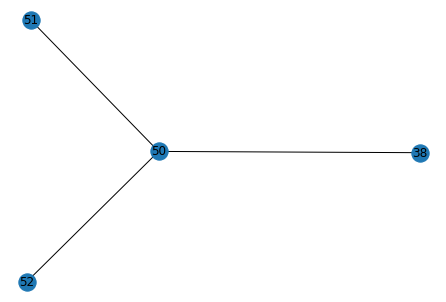

match_branches = [[38, 52]]
edges_to_delete (resolve crossover) = [[38, 50], [38, 51], [50, 51], [50, 52], [51, 52]]
edges_to_create (resolve crossover) = [[38, 52]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 101 because skeletal distance was 217.80425559022382 and threshold was 2500
skip_nodes = [101]
edges_to_delete (cut_limb_network) = [[38, 50], [38, 51], [50, 51], [50, 52], [51, 52]]
edges_to_create = [[38, 52]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 52, 55, 56, 57, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 1

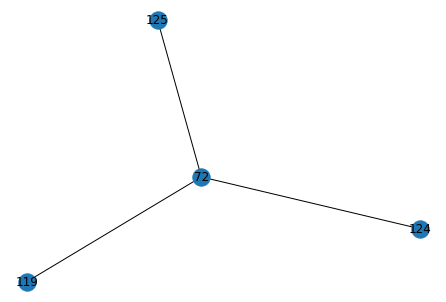

match_branches = [[72, 125], [119, 124]]
edges_to_delete (resolve crossover) = [[72, 119], [72, 124], [119, 125], [124, 125]]
edges_to_create (resolve crossover) = [[72, 125], [119, 124]]
curr_limb.deleted_edges 5 =[[38, 50], [38, 51], [50, 51], [50, 52], [51, 52]]
Skipping endnode 101 because skeletal distance was 217.80425559022382 and threshold was 2500
skip_nodes = [101]
edges_to_delete (cut_limb_network) = [[72, 119], [72, 124], [119, 125], [124, 125]]
edges_to_create = [[72, 125], [119, 124]]
Number of connected components = 5
Comp 0 = {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 52, 55, 56, 57, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 12

  Edge: [100  97]: curr_angle = 27.51
  Edge: [97 90]: curr_angle = 13.43
  Edge: [90 83]: curr_angle = 8.94
  Edge: [83 77]: curr_angle = 17.77
  Edge: [77 73]: curr_angle = 10.79
  Edge: [73 66]: curr_angle = 28.31
  Edge: [66 63]: curr_angle = 31.4
  Edge: [63 46]: curr_angle = 10.34
  Edge: [46 43]: curr_angle = 19.11
  Edge: [43 37]: curr_angle = 12.29
  Edge: [37 33]: curr_angle = 10.98
  Edge: [33 32]: curr_angle = 12.26
  Edge: [32 27]: curr_angle = 15.37
  Edge: [27 23]: curr_angle = 33.34
  Edge: [23 24]: curr_angle = 36.15
  Edge: [24 31]: curr_angle = 15.35
  Edge: [31 26]: curr_angle = 16.73
  Edge: [26 22]: curr_angle = 25.26
  Edge: [22 72]: curr_angle = 17.07
  Edge: [ 72 125]: curr_angle = 10.59
  Edge: [125 134]: curr_angle = 28.76
  Edge: [134 144]: curr_angle = 60.89
  Edge: [144 147]: curr_angle = 24.54
  Edge: [147 156]: curr_angle = 34.19
  Edge: [156 153]: curr_angle = 41.95
  Edge: [153 154]: curr_angle = 27.95

Total time for doubling_back = 1.5888164043426514

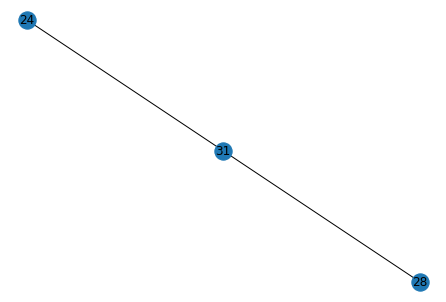

match_branches = [[28, 31]]
edges_to_delete (resolve crossover) = [[24, 28], [24, 31]]
edges_to_create (resolve crossover) = [[28, 31]]
edges_to_delete (cut_limb_network) = [array([24, 28]), array([24, 31])]
edges_to_create = [[28, 31]]
Number of connected components = 6
Comp 0 = {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 18, 19, 20, 23, 24, 27, 32, 33, 34, 37, 38, 39, 40, 41, 43, 45, 46, 52, 55, 57, 59, 60, 62, 63, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 126, 128}
Comp 1 = {4, 76, 44, 47, 49, 50, 54, 58, 61}
Comp 2 = {48, 25, 51}
Comp 3 = {129, 130, 131, 132, 133, 134, 135, 158, 137, 138, 136, 140, 13, 155, 141, 16, 17, 144, 147, 148, 149, 22, 150, 151, 153, 26, 154, 28, 29, 30, 31, 156, 160, 161, 35, 36, 157, 165, 166, 162, 159, 42, 163, 164, 56, 139, 64, 72, 142, 143, 145, 91, 94, 146, 95, 105, 2

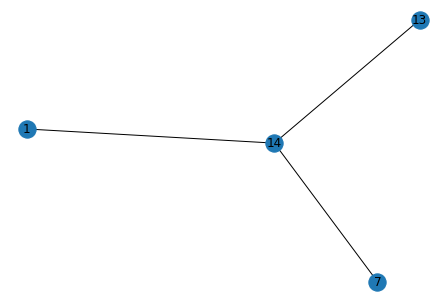

match_branches = [[1, 14]]
edges_to_delete (resolve crossover) = [[1, 7], [1, 13], [7, 13], [7, 14], [13, 14]]
edges_to_create (resolve crossover) = [[1, 14]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 7], [1, 13], [7, 13], [7, 14], [13, 14]]
edges_to_create = [[1, 14]]
Number of connected components = 2
Comp 0 = {1, 4, 9, 13, 14, 15, 17, 18, 19, 20, 23, 24, 25, 26, 27}
Comp 1 = {0, 2, 3, 5, 6, 7, 8, 10, 11, 12, 16, 21, 22}
curr_limb_copy.deleted_edges = [[1, 7], [1, 13], [7, 13], [7, 14], [13, 14]]
curr_limb_copy.created_edges = [[1, 14]]
After get best cut: cut_edges = [[1, 7], [1, 13], [7, 13], [7, 14], [13, 14]], added_edges = [[1, 14]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of 

  Edge: [27 28]: curr_angle = 22.72
  Edge: [28 29]: curr_angle = 19.64
  Edge: [29 23]: curr_angle = 6.94
  Edge: [23 22]: curr_angle = 19.4
  Edge: [22 12]: curr_angle = 16.35
  Edge: [12  9]: curr_angle = 34.86
  Edge: [ 9 10]: curr_angle = 38.92
  Edge: [10 16]: curr_angle = 5.91
  Edge: [16 20]: curr_angle = 25.19
  Edge: [20 37]: curr_angle = 42.05
  Edge: [37 46]: curr_angle = 44.19
  Edge: [46 49]: curr_angle = 12.19
  Edge: [49 48]: curr_angle = 8.93
  Edge: [48 53]: curr_angle = 27.13
  Edge: [53 54]: curr_angle = 60.78
  Edge: [54 50]: curr_angle = 7.8

Total time for doubling_back = 1.2095813751220703

Attempting the width jump check (attempting from both sides)
  Edge: [27 28]: jump = -267.56
  Edge: [28 29]: jump = -170.21
  Edge: [29 23]: jump = -60.47
  Edge: [23 22]: jump = -30.97
  Edge: [22 12]: jump = -21.52
  Edge: [12  9]: jump = -72.84
  Edge: [ 9 10]: jump = -0.34
  Edge: [10 16]: jump = -46.54
  Edge: [16 20]: jump = -206.24
  Edge: [20 37]: jump = 208.31
Addin

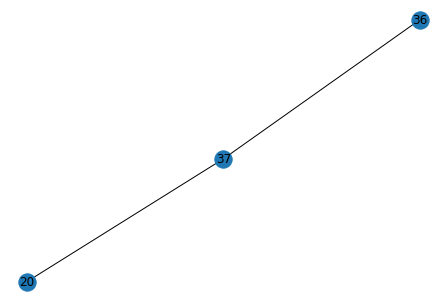

match_branches = [[36, 37]]
edges_to_delete (resolve crossover) = [[20, 36], [20, 37]]
edges_to_create (resolve crossover) = [[36, 37]]
edges_to_delete (cut_limb_network) = [array([20, 36]), array([20, 37])]
edges_to_create = [[36, 37]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 38}
Comp 1 = {11, 18, 21, 34, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70}
curr_limb_copy.deleted_edges = [array([20, 36]), array([20, 37])]
curr_limb_copy.created_edges = [[36, 37]]
After get best cut: cut_edges = [array([20, 36]), array([20, 37])], added_edges = [[36, 37]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path

  Edge: [6 7]: curr_angle = 65.57
  Edge: [ 7 18]: curr_angle = 29.07
  Edge: [18 19]: curr_angle = 56.35
  Edge: [19 21]: curr_angle = 23.07
  Edge: [21 23]: curr_angle = 51.76

Total time for doubling_back = 0.6257545948028564

Attempting the width jump check (attempting from both sides)
  Edge: [6 7]: jump = 29.76
  Edge: [ 7 18]: jump = 187.75
  Edge: [18 19]: jump = 294.6
Adding error edge [18 19] because width jump was 294.5989754489158
  Edge: [19 21]: jump = -68.38
  Edge: [21 23]: jump = 218.15
Adding error edge [21 23] because width jump was 218.15373798533233
Total time for width = 0.5738658905029297
Path starting at 6 had err_edges: [[18, 19], [21, 23]]
  Edge: [23 21]: jump = -218.15
  Edge: [21 19]: jump = 68.38
  Edge: [19 18]: jump = -294.6
  Edge: [18  7]: jump = -187.75
  Edge: [7 6]: jump = -29.76
Total time for width = 0.5746595859527588
Path starting at 23 had err_edges: []
first_error_sizes = [294.5989754489158, -inf], winning_path = 0
***inside resolve crossover!

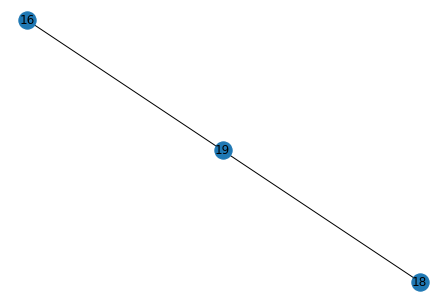

match_branches = []
edges_to_delete (resolve crossover) = [[16, 18], [16, 19], [18, 19]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([16, 18]), array([16, 19]), array([18, 19])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {6, 7, 8, 14, 18}
Comp 1 = {0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 15, 16, 17, 20}
Comp 2 = {19, 21, 22, 23, 24}
curr_limb_copy.deleted_edges = [array([16, 18]), array([16, 19]), array([18, 19])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([16, 18]), array([16, 19]), array([18, 19])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([ 6,  7,  8, 14, 18]), array([ 0,  1,  2,  3,  4,  5,  9, 

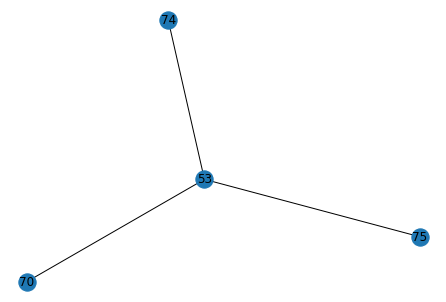

match_branches = [[53, 75], [70, 74]]
edges_to_delete (resolve crossover) = [[53, 70], [53, 74], [70, 75], [74, 75]]
edges_to_create (resolve crossover) = [[53, 75], [70, 74]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[53, 70], [53, 74], [70, 75], [74, 75]]
edges_to_create = [[53, 75], [70, 74]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35.0, 37, 38, 39, 40, 41, 42, 43, 47, 48, 49, 50, 51, 52, 53, 56, 58, 60, 64, 69, 75, 77, 78}
Comp 1 = {36, 44, 45, 46, 54, 55, 57, 59, 61, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 74, 76}
curr_limb_copy.deleted_edges = [[53, 70], [53, 74], [70, 75], [74, 75]]
curr_limb_copy.created_edges = [[53, 75], [70, 74]]
After get best cut: cut_edges = [[53, 70], [53, 74], [70, 75], [74, 75]], added_edges = [[53, 75], [70, 74]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 

  Edge: [33 30]: curr_angle = 37.8
  Edge: [30 37]: curr_angle = 65.31
  Edge: [37 53]: curr_angle = 31.48
  Edge: [53 75]: curr_angle = 13.09

Total time for doubling_back = 0.3661010265350342

Attempting the width jump check (attempting from both sides)
  Edge: [33 30]: jump = 85.32
  Edge: [30 37]: jump = -585.79
  Edge: [37 53]: jump = -23.74
  Edge: [53 75]: jump = -9.48
Total time for width = 0.3656489849090576
Path starting at 33 had err_edges: []
  Edge: [75 53]: jump = 9.48
  Edge: [53 37]: jump = 23.74
  Edge: [37 30]: jump = 585.79
Adding error edge [37 30] because width jump was 585.7860881705531
  Edge: [30 33]: jump = -85.32
Total time for width = 0.2521994113922119
Path starting at 75 had err_edges: [[37, 30]]
first_error_sizes = [-inf, 585.7860881705531], winning_path = 1
***inside resolve crossover!!!!****
coordinate_branches = [26, 30, 37]
26 = red
30 = aqua
37 = purple
Angle between 26 and 30 = 26.69 
Angle between 26 and 37 = 95.72 
Angle between 30 and 37 = 58.39 


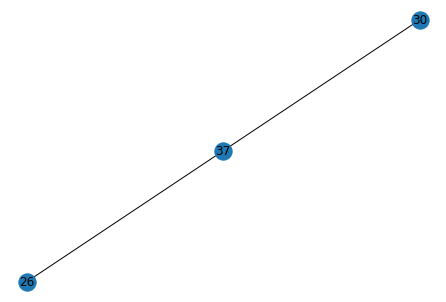

match_branches = [[26, 30]]
edges_to_delete (resolve crossover) = [[26, 37], [30, 37]]
edges_to_create (resolve crossover) = [[26, 30]]
edges_to_delete (cut_limb_network) = [array([26, 37]), array([30, 37])]
edges_to_create = [[26, 30]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35.0, 38, 39, 40, 41, 42, 43, 47, 48, 50, 51, 52, 56, 58, 60, 64, 69, 77, 78}
Comp 1 = {49, 75, 53, 37}
Comp 2 = {36, 44, 45, 46, 54, 55, 57, 59, 61, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 74, 76}
curr_limb_copy.deleted_edges = [[53, 70], [53, 74], [70, 75], [74, 75], array([26, 37]), array([30, 37])]
curr_limb_copy.created_edges = [[53, 75], [70, 74], [26, 30]]
After get best cut: cut_edges = [array([26, 37]), array([30, 37])], added_edges = [[26, 30]]
total_soma_paths_to_cut = [[53, 70], [53, 74], [70, 75], [74, 75]]
-----------counter = 1------------
 Cut iteration 2
Total numb

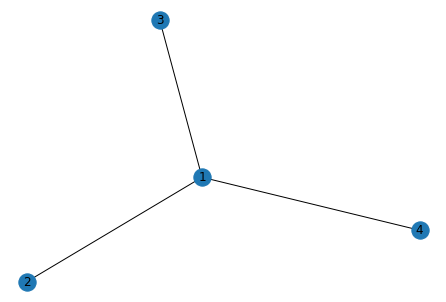

match_branches = [[1, 3]]
edges_to_delete (resolve crossover) = [[1, 2], [1, 4], [2, 3], [2, 4], [3, 4]]
edges_to_create (resolve crossover) = [[1, 3]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 5 because skeletal distance was 1892.7487816962093 and threshold was 2500
skip_nodes = [5]
edges_to_delete (cut_limb_network) = [[1, 2], [1, 4], [2, 3], [2, 4], [3, 4]]
edges_to_create = [[1, 3]]
Number of connected components = 3
Comp 0 = {1, 3}
Comp 1 = {0, 2, 5}
Comp 2 = {4}
curr_limb_copy.deleted_edges = [[1, 2], [1, 4], [2, 3], [2, 4], [3, 4]]
curr_limb_copy.created_edges = [[1, 3]]
After get best cut: cut_edges = [[1, 2], [1, 4], [2, 3], [2, 4], [3, 4]], added_edges = [[1, 3]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the spl

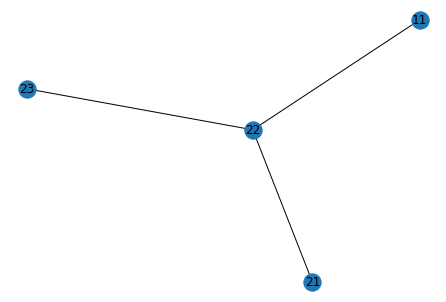

match_branches = [[11, 23]]
edges_to_delete (resolve crossover) = [[11, 21], [11, 22], [21, 22], [21, 23], [22, 23]]
edges_to_create (resolve crossover) = [[11, 23]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 45 because skeletal distance was 381.9745122148444 and threshold was 2500
skip_nodes = [45]
edges_to_delete (cut_limb_network) = [[11, 21], [11, 22], [21, 22], [21, 23], [22, 23]]
edges_to_create = [[11, 23]]
Number of connected components = 3
Comp 0 = {2, 3, 6, 8, 9, 11, 12, 13, 18, 20, 23, 24, 25, 26, 27, 28, 29, 31, 32, 35, 37, 39, 41, 47, 48, 50, 51, 52, 53, 54, 59, 61, 62, 63, 64, 65, 66, 68, 69, 72, 79, 80}
Comp 1 = {7, 14, 15, 17, 21}
Comp 2 = {0, 1, 4, 5, 10, 16, 19, 22, 30, 33, 34, 36, 38, 40, 42, 43, 44, 45, 46, 49, 55, 56, 57, 58, 60, 67, 70, 71, 73, 74, 75, 76, 77, 78, 81, 82, 83, 84}
curr_limb_copy.deleted_edges = [[11, 21], [11, 22], [21, 22], [21, 23], [22, 23]]
curr_limb_copy.created_edges = [[11, 23]]
After get best cut: cut_edges = [[11, 21], [11, 22], [21, 2

  Edge: [41 37]: curr_angle = 20.4
  Edge: [37 38]: curr_angle = 45.12
  Edge: [38 49]: curr_angle = 54.36
  Edge: [49 55]: curr_angle = 9.54
  Edge: [55 73]: curr_angle = 14.48
  Edge: [73 74]: curr_angle = 19.47

Total time for doubling_back = 1.1921932697296143

Attempting the width jump check (attempting from both sides)
  Edge: [41 37]: jump = -173.45
  Edge: [37 38]: jump = 11.19
  Edge: [38 49]: jump = -209.22
  Edge: [49 55]: jump = 283.32
Adding error edge [49 55] because width jump was 283.31946484595494
  Edge: [55 73]: jump = 97.07
  Edge: [73 74]: jump = 172.89
Total time for width = 0.7984817028045654
Path starting at 41 had err_edges: [[49, 55]]
  Edge: [74 73]: jump = -172.89
  Edge: [73 55]: jump = -97.07
  Edge: [55 49]: jump = -283.32
  Edge: [49 38]: jump = 209.22
Adding error edge [49 38] because width jump was 209.22388361479392
  Edge: [38 37]: jump = -11.19
  Edge: [37 41]: jump = 173.45
Total time for width = 0.8879456520080566
Path starting at 74 had err_edges

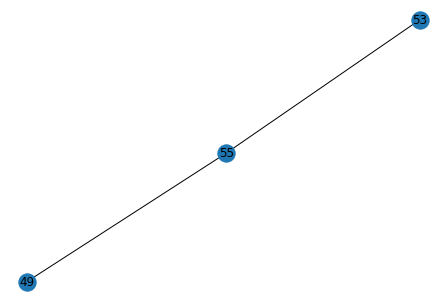

match_branches = [[49, 55]]
edges_to_delete (resolve crossover) = [[49, 53], [53, 55]]
edges_to_create (resolve crossover) = [[49, 55]]
Rejecting creating edge [49, 55] becuase did not involve only 1 node in the deleted edge
edges_to_delete (cut_limb_network) = [array([49, 53]), array([49, 55]), array([53, 55])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {34, 35, 37, 38, 40, 41, 11, 48, 49, 19, 28}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 36, 39, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 65, 66, 67, 68, 70, 71}
Comp 2 = {64, 69, 72, 73, 74, 55, 63}
curr_limb_copy.deleted_edges = [array([49, 53]), array([49, 55]), array([53, 55])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([49, 53]), array([49, 55]), array([53, 55])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total numb

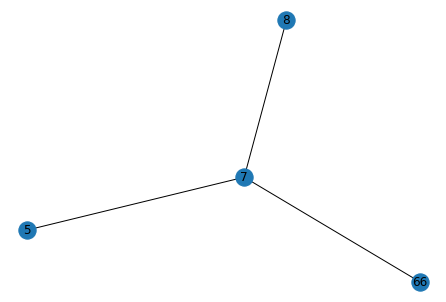

match_branches = [[5, 7]]
edges_to_delete (resolve crossover) = [[5, 8], [5, 66], [7, 8], [7, 66], [8, 66]]
edges_to_create (resolve crossover) = [[5, 7]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 9 because skeletal distance was 1215.5880193299954 and threshold was 2500
skip_nodes = [9]
edges_to_delete (cut_limb_network) = [[5, 8], [5, 66], [7, 8], [7, 66], [8, 66]]
edges_to_create = [[5, 7]]
Number of connected components = 4
Comp 0 = {4, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65}
Comp 1 = {0, 1, 2, 3, 5, 6, 7, 9}
Comp 2 = {66}
Comp 3 = {23}
curr_limb_copy.deleted_edges = [[5, 8], [5, 66], [7, 8], [7, 66], [8, 66]]
curr_limb_copy.created_edges = [[5, 7]]
After get best cut: cut_edges = [[5, 8], [5, 66], [7, 8], [7, 66], [8, 66]], added_edges = [[5, 7]]
total_soma_paths_to_cut = []
-----------counter = 0

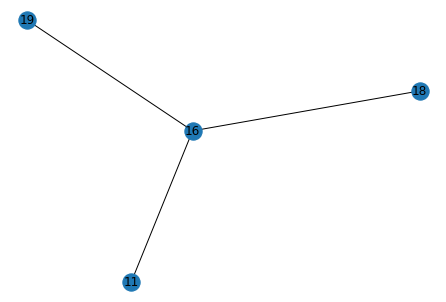

match_branches = [[11, 18], [16, 19]]
edges_to_delete (resolve crossover) = [[11, 16], [11, 19], [16, 18], [18, 19]]
edges_to_create (resolve crossover) = [[11, 18], [16, 19]]
curr_limb.deleted_edges 5 =[[5, 8], [5, 66], [7, 8], [7, 66], [8, 66]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[11, 16], [11, 19], [16, 18], [18, 19]]
edges_to_create = [[11, 18], [16, 19]]
Number of connected components = 4
Comp 0 = {4, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65}
Comp 1 = {0, 1, 2, 3, 5, 6, 7, 9}
Comp 2 = {66}
Comp 3 = {23}
curr_limb_copy.deleted_edges = [[5, 8], [5, 66], [7, 8], [7, 66], [8, 66], [11, 16], [11, 19], [16, 18], [18, 19]]
curr_limb_copy.created_edges = [[5, 7], [11, 18], [16, 19]]
After get best cut: cut_edges = [[11, 16], [11, 19], [16, 18], [18, 19]], added_edges = [[11, 18], [16, 19]]
tot

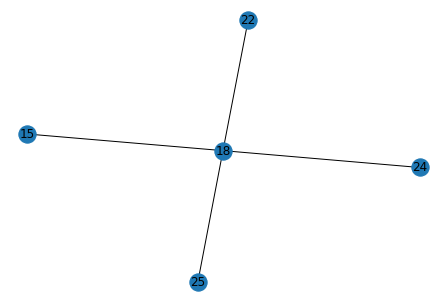

match_branches = [[18, 24]]
edges_to_delete (resolve crossover) = [[15, 18], [15, 22], [15, 24], [15, 25], [18, 22], [18, 25], [22, 24], [22, 25], [24, 25]]
edges_to_create (resolve crossover) = [[18, 24]]
curr_limb.deleted_edges 5 =[[5, 8], [5, 66], [7, 8], [7, 66], [8, 66], [11, 16], [11, 19], [16, 18], [18, 19]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[15, 18], [15, 22], [15, 24], [15, 25], [18, 22], [18, 25], [22, 24], [22, 25], [24, 25]]
edges_to_create = [[18, 24]]
Number of connected components = 8
Comp 0 = {4, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 24, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65}
Comp 1 = {15}
Comp 2 = {22}
Comp 3 = {33, 34, 8, 52, 53, 54, 25, 57}
Comp 4 = {0, 1, 2, 3, 5, 6, 7, 9}
Comp 5 = {66}
Comp 6 = {23}
Comp 7 = {49}
curr_limb_copy.deleted_edges = [[5, 8], [5, 66], [7, 8], [7, 66], [8, 66], [11, 16], [11, 19], [16, 18], [18, 19], [15, 18], [15, 22], [1

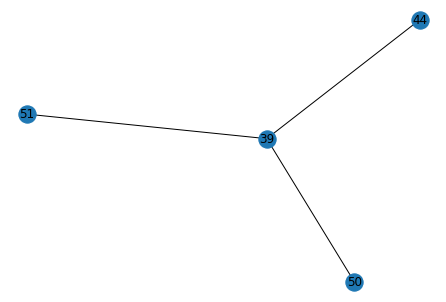

match_branches = [[44, 50], [39, 51]]
edges_to_delete (resolve crossover) = [[39, 44], [39, 50], [44, 51], [50, 51]]
edges_to_create (resolve crossover) = [[44, 50], [39, 51]]
curr_limb.deleted_edges 5 =[[5, 8], [5, 66], [7, 8], [7, 66], [8, 66], [11, 16], [11, 19], [16, 18], [18, 19], [15, 18], [15, 22], [15, 24], [15, 25], [18, 22], [18, 25], [22, 24], [22, 25], [24, 25]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[39, 44], [39, 50], [44, 51], [50, 51]]
edges_to_create = [[44, 50], [39, 51]]
Number of connected components = 9
Comp 0 = {4, 10, 12, 13, 14, 16, 17, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 41, 42, 43, 44, 47, 48, 50, 55, 56, 58, 59, 60, 61}
Comp 1 = {64, 65, 39, 40, 11, 45, 46, 18, 51, 24, 62, 63}
Comp 2 = {15}
Comp 3 = {22}
Comp 4 = {33, 34, 8, 52, 53, 54, 25, 57}
Comp 5 = {0, 1, 2, 3, 5, 6, 7, 9}
Comp 6 = {66}
Comp 7 = {23}
Comp 8 = {49}
curr_limb_copy.deleted_edges = [[5, 8], [5, 66], [7, 8], [7, 66], [8, 66], [11, 16], [11, 19], [16, 18], [1

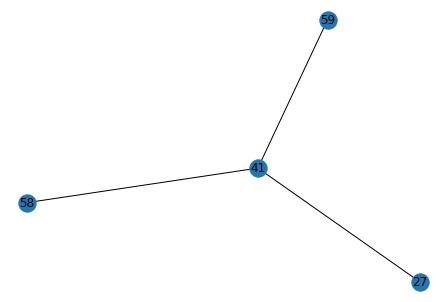

match_branches = [[41, 59], [27, 58]]
edges_to_delete (resolve crossover) = [[27, 41], [27, 59], [41, 58], [58, 59]]
edges_to_create (resolve crossover) = [[41, 59], [27, 58]]
curr_limb.deleted_edges 5 =[[5, 8], [5, 66], [7, 8], [7, 66], [8, 66], [11, 16], [11, 19], [16, 18], [18, 19], [15, 18], [15, 22], [15, 24], [15, 25], [18, 22], [18, 25], [22, 24], [22, 25], [24, 25], [39, 44], [39, 50], [44, 51], [50, 51]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[27, 41], [27, 59], [41, 58], [58, 59]]
edges_to_create = [[41, 59], [27, 58]]
Number of connected components = 10
Comp 0 = {32, 41, 10, 42, 16, 17, 19, 59, 31}
Comp 1 = {64, 65, 39, 40, 11, 45, 46, 18, 51, 24, 62, 63}
Comp 2 = {15}
Comp 3 = {22}
Comp 4 = {33, 34, 8, 52, 53, 54, 25, 57}
Comp 5 = {4, 12, 13, 14, 20, 21, 26, 27, 28, 29, 30, 35, 36, 37, 38, 43, 44, 47, 48, 50, 55, 56, 58, 60, 61}
Comp 6 = {0, 1, 2, 3, 5, 6, 7, 9}
Comp 7 = {66}
Comp 8 = {23}
Comp 9 = {49}
curr_limb_copy.deleted_edges = [[5, 8], [5, 66], [7, 8],

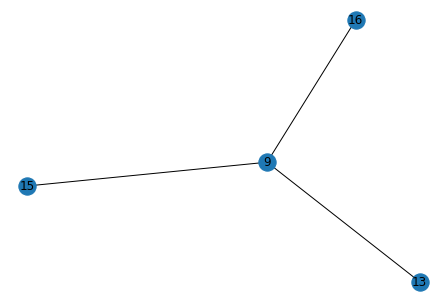

match_branches = [[13, 16], [9, 15]]
edges_to_delete (resolve crossover) = [[9, 13], [9, 16], [13, 15], [15, 16]]
edges_to_create (resolve crossover) = [[13, 16], [9, 15]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[9, 13], [9, 16], [13, 15], [15, 16]]
edges_to_create = [[13, 16], [9, 15]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 4, 6, 10, 13, 16, 17, 20}
Comp 1 = {3, 5, 7, 8, 9, 11, 12, 15, 18, 19, 21, 22}
Comp 2 = {14}
curr_limb_copy.deleted_edges = [[9, 13], [9, 16], [13, 15], [15, 16]]
curr_limb_copy.created_edges = [[13, 16], [9, 15]]
After get best cut: cut_edges = [[9, 13], [9, 16], [13, 15], [15, 16]], added_edges = [[13, 16], [9, 15]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconn

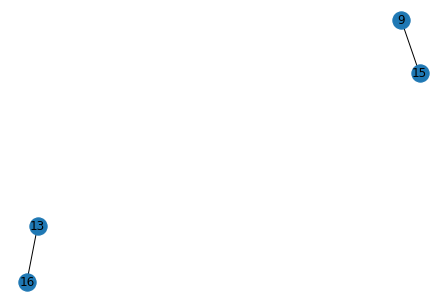

match_branches = [[13, 16], [9, 15]]
edges_to_delete (resolve crossover) = [[9, 13], [9, 16], [13, 15], [15, 16]]
edges_to_create (resolve crossover) = [[13, 16], [9, 15]]
curr_limb.deleted_edges 5 =[[9, 13], [9, 16], [13, 15], [15, 16]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[9, 13], [9, 16], [13, 15], [15, 16]]
edges_to_create = [[13, 16], [9, 15]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 4, 6, 10, 13, 16, 17, 20}
Comp 1 = {3, 5, 7, 8, 9, 11, 12, 15, 18, 19, 21, 22}
Comp 2 = {14}
curr_limb_copy.deleted_edges = [[9, 13], [9, 16], [13, 15], [15, 16], [9, 13], [9, 16], [13, 15], [15, 16]]
curr_limb_copy.created_edges = [[13, 16], [9, 15], [13, 16], [9, 15]]
After get best cut: cut_edges = [[9, 13], [9, 16], [13, 15], [15, 16]], added_edges = [[13, 16], [9, 15]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFT

  Edge: [5 8]: curr_angle = 83.05
  Edge: [8 9]: curr_angle = 128.4
  Edge: [ 9 15]: curr_angle = 14.43
  Edge: [15 18]: curr_angle = 38.46

Total time for doubling_back = 0.2002730369567871
There were 1 edges that passed doubling back threshold of 100
Winning edge [8 9] had a doubling back of 128.4034006746129
***inside resolve crossover!!!!****
coordinate_branches = [8, 9, 11]
8 = red
9 = aqua
11 = purple
Angle between 8 and 9 = 87.96 
Angle between 8 and 11 = 52.78 
Angle between 9 and 11 = 39.41 
Final Matches = []
matched_branches_revised = []
Original graph


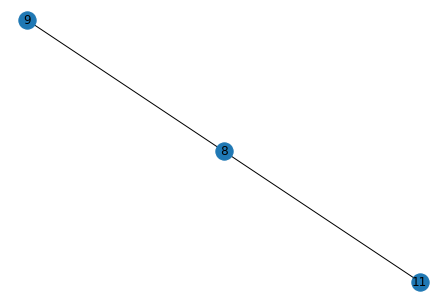

match_branches = []
edges_to_delete (resolve crossover) = [[8, 9], [8, 11], [9, 11]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([8, 9]), array([ 8, 11]), array([ 9, 11])]
edges_to_create = []
Number of connected components = 5
Comp 0 = {0, 1, 2, 4, 6, 10, 13, 16, 17, 20}
Comp 1 = {9, 15, 18, 19, 21, 22}
Comp 2 = {8, 5, 7}
Comp 3 = {3, 11, 12}
Comp 4 = {14}
curr_limb_copy.deleted_edges = [[9, 13], [9, 16], [13, 15], [15, 16], [9, 13], [9, 16], [13, 15], [15, 16], array([8, 9]), array([ 8, 11]), array([ 9, 11])]
curr_limb_copy.created_edges = [[13, 16], [9, 15], [13, 16], [9, 15]]
After get best cut: cut_edges = [array([8, 9]), array([ 8, 11]), array([ 9, 11])], added_edges = []
total_soma_paths_to_cut = [[9, 13], [9, 16], [13, 15], [15, 16]]
-----------counter = 1------------
 Cut iteration 2
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 5
Total number of graphs at the end of the split AFTER DIRECTIONAL = 5
No valid path so

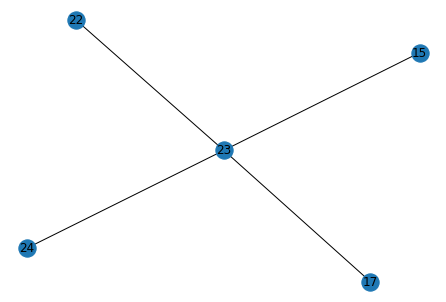

match_branches = [[17, 24], [15, 23]]
edges_to_delete (resolve crossover) = [[15, 17], [15, 22], [15, 24], [17, 22], [17, 23], [22, 23], [22, 24], [23, 24]]
edges_to_create (resolve crossover) = [[17, 24], [15, 23]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[15, 17], [15, 22], [15, 24], [17, 22], [17, 23], [22, 23], [22, 24], [23, 24]]
edges_to_create = [[17, 24], [15, 23]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21.0, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33.0, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91}
Comp 1 = {22}
curr_limb_copy.deleted_edges = [[15, 17], [15, 22], [15, 24], [17, 22], [17, 23], [22, 23], [22, 24], [23, 24]]
curr_limb_copy.created_edges = [[17, 24], [15, 23]]


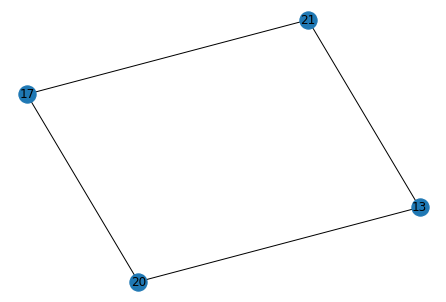

match_branches = [[13, 17]]
edges_to_delete (resolve crossover) = [[13, 20], [13, 21], [17, 20], [17, 21], [20, 21]]
edges_to_create (resolve crossover) = [[13, 17]]
curr_limb.deleted_edges 5 =[[15, 17], [15, 22], [15, 24], [17, 22], [17, 23], [22, 23], [22, 24], [23, 24]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[13, 20], [13, 21], [17, 20], [17, 21], [20, 21]]
edges_to_create = [[13, 17]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 18, 19, 20, 21.0, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33.0, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91}
Comp 1 = {24, 17, 13}
Comp 2 = {22}
Comp 3 = {16}
curr_limb_copy.deleted_edges = [[15, 17], [15, 22], [15, 24], [17, 22], [17, 23], [22, 23], [22, 24], [23, 24], [13, 20], [13, 21], [17, 20], [17, 21], [20,

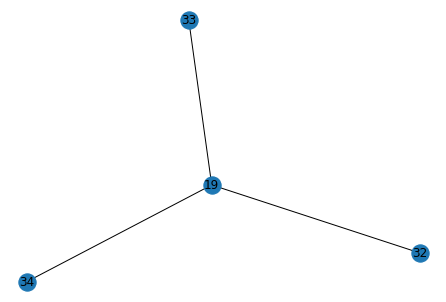

match_branches = [[19, 34]]
edges_to_delete (resolve crossover) = [[19, 32], [19, 33], [32, 33], [32, 34], [33, 34]]
edges_to_create (resolve crossover) = [[19, 34]]
curr_limb.deleted_edges 5 =[[15, 17], [15, 22], [15, 24], [17, 22], [17, 23], [22, 23], [22, 24], [23, 24], [13, 20], [13, 21], [17, 20], [17, 21], [20, 21]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[19, 32], [19, 33], [32, 33], [32, 34], [33, 34]]
edges_to_create = [[19, 34]]
Number of connected components = 5
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 18, 19, 26, 27, 28, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91}
Comp 1 = {32, 33.0, 15, 20, 21.0, 23, 25, 29, 30}
Comp 2 = {24, 17, 13}
Comp 3 = {22}
Comp 4 = {16}
curr_limb_copy.deleted_edges = [[15, 17], [15, 22], [15, 24], [17, 22], [17, 23], [22, 23], [22,

  Edge: [14 26]: curr_angle = 18.31
  Edge: [26 18]: curr_angle = 16.21
  Edge: [18 19]: curr_angle = 32.87
  Edge: [19 34]: curr_angle = 8.97
  Edge: [34 39]: curr_angle = 38.51
  Edge: [39 35]: curr_angle = 58.95
  Edge: [35 36]: curr_angle = 138.88
  Edge: [36 53]: curr_angle = 16.14
  Edge: [53 58]: curr_angle = 44.1
  Edge: [58 66]: curr_angle = 23.06
  Edge: [66 67]: curr_angle = 59.62
  Edge: [67 68]: curr_angle = 19.71
  Edge: [68 70]: curr_angle = 45.24
  Edge: [70 73]: curr_angle = 34.7
  Edge: [73 74]: curr_angle = 17.25

Total time for doubling_back = 1.1527934074401855
There were 1 edges that passed doubling back threshold of 100
Winning edge [35 36] had a doubling back of 138.88379858454127
***inside resolve crossover!!!!****
coordinate_branches = [12, 35, 36]
12 = red
35 = aqua
36 = purple
Angle between 12 and 35 = 59.66 
Angle between 12 and 36 = 30.1 
Angle between 35 and 36 = 141.3 
Final Matches = [[12, 36]]
matched_branches_revised = [[12, 36]]
Original graph


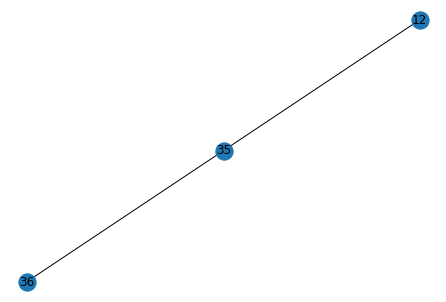

match_branches = [[12, 36]]
edges_to_delete (resolve crossover) = [[12, 35], [35, 36]]
edges_to_create (resolve crossover) = [[12, 36]]
edges_to_delete (cut_limb_network) = [array([12, 35]), array([35, 36])]
edges_to_create = [[12, 36]]
Number of connected components = 6
Comp 0 = {1, 2, 12, 36, 53, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89}
Comp 1 = {0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 18, 19, 26, 27, 28, 31, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 90, 91}
Comp 2 = {32, 33.0, 15, 20, 21.0, 23, 25, 29, 30}
Comp 3 = {24, 17, 13}
Comp 4 = {22}
Comp 5 = {16}
curr_limb_copy.deleted_edges = [[15, 17], [15, 22], [15, 24], [17, 22], [17, 23], [22, 23], [22, 24], [23, 24], [13, 20], [13, 21], [17, 20], [17, 21], [20, 21], [19, 32], [19, 33], [32, 33], [32, 34], [33, 34], array([12, 35]), array([35, 36])]
curr_limb_copy.created_edges = [[17, 24], [15, 23], [13, 17]

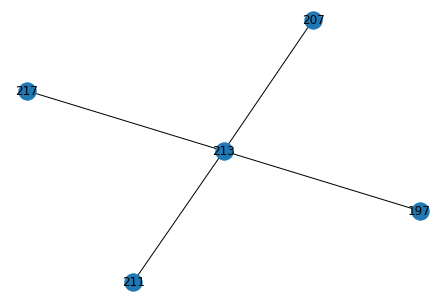

match_branches = [[207, 213], [211, 217]]
edges_to_delete (resolve crossover) = [[197, 207], [197, 211], [197, 213], [197, 217], [207, 211], [207, 217], [211, 213], [213, 217]]
edges_to_create (resolve crossover) = [[207, 213], [211, 217]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 229 because skeletal distance was 963.9785438474959 and threshold was 2500
skip_nodes = [229]
edges_to_delete (cut_limb_network) = [[197, 207], [197, 211], [197, 213], [197, 217], [207, 211], [207, 217], [211, 213], [213, 217]]
edges_to_create = [[207, 213], [211, 217]]
Number of connected components = 5
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 10

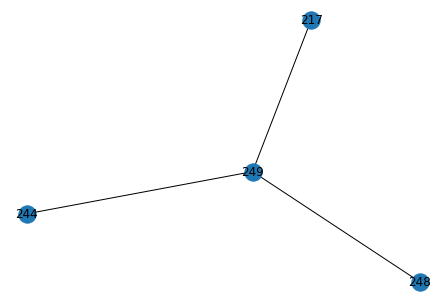

match_branches = []
edges_to_delete (resolve crossover) = [[217, 244], [217, 248], [217, 249], [244, 248], [244, 249], [248, 249]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[[197, 207], [197, 211], [197, 213], [197, 217], [207, 211], [207, 217], [211, 213], [213, 217]]
Skipping endnode 229 because skeletal distance was 963.9785438474959 and threshold was 2500
skip_nodes = [229]
edges_to_delete (cut_limb_network) = [[217, 244], [217, 248], [217, 249], [244, 248], [244, 249], [248, 249]]
edges_to_create = []
Number of connected components = 8
Comp 0 = {256, 194, 235, 220, 249, 252, 253, 254, 255}
Comp 1 = {217, 211, 209, 203}
Comp 2 = {265, 266, 142, 273, 274, 279, 280, 287, 289, 290, 292, 294, 295, 296, 298, 299, 300, 301, 302, 303, 304, 306, 307, 196, 244}
Comp 3 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,

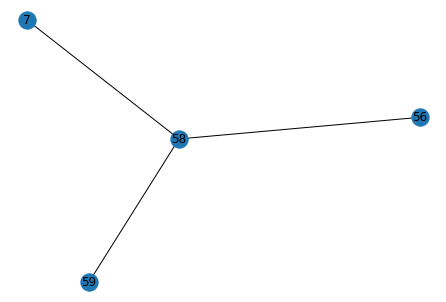

match_branches = [[7, 56]]
edges_to_delete (resolve crossover) = [[7, 58], [7, 59], [56, 58], [56, 59], [58, 59]]
edges_to_create (resolve crossover) = [[7, 56]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 37 because skeletal distance was 927.7401048473248 and threshold was 2500
skip_nodes = [37]
edges_to_delete (cut_limb_network) = [[7, 58], [7, 59], [56, 58], [56, 59], [58, 59]]
edges_to_create = [[7, 56]]
Number of connected components = 3
Comp 0 = {2, 4, 7, 139, 140, 27, 41, 42, 48, 49, 50, 51, 54, 55, 56, 57, 68, 78, 82, 83, 84, 86, 89, 94, 105}
Comp 1 = {0, 1, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 52, 53, 58, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 85, 87, 88, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,

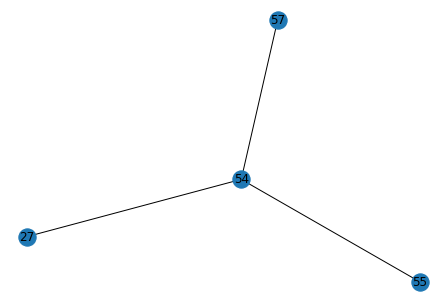

match_branches = [[55, 57]]
edges_to_delete (resolve crossover) = [[27, 54], [27, 55], [27, 57], [54, 55], [54, 57]]
edges_to_create (resolve crossover) = [[55, 57]]
curr_limb.deleted_edges 5 =[[7, 58], [7, 59], [56, 58], [56, 59], [58, 59]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[27, 54], [27, 55], [27, 57], [54, 55], [54, 57]]
edges_to_create = [[55, 57]]
Number of connected components = 5
Comp 0 = {2, 68, 7, 105, 41, 139, 140, 78, 82, 83, 84, 86, 55, 56, 89, 94, 57}
Comp 1 = {27}
Comp 2 = {4, 42, 48, 49, 50, 51, 54}
Comp 3 = {0, 1, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 52, 53, 58, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 85, 87, 88, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,

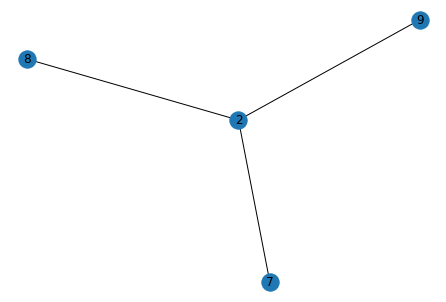

match_branches = [[7, 9], [2, 8]]
edges_to_delete (resolve crossover) = [[2, 7], [2, 9], [7, 8], [8, 9]]
edges_to_create (resolve crossover) = [[7, 9], [2, 8]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[2, 7], [2, 9], [7, 8], [8, 9]]
edges_to_create = [[7, 9], [2, 8]]
Number of connected components = 2
Comp 0 = {8, 2}
Comp 1 = {0, 1, 3, 4, 5, 6, 7, 9, 10, 11}
curr_limb_copy.deleted_edges = [[2, 7], [2, 9], [7, 8], [8, 9]]
curr_limb_copy.created_edges = [[7, 9], [2, 8]]
After get best cut: cut_edges = [[2, 7], [2, 9], [7, 8], [8, 9]], added_edges = [[7, 9], [2, 8]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([8, 2]), array([ 0,  1,  3,  4,  5,  6,  7,  9, 10, 11])]



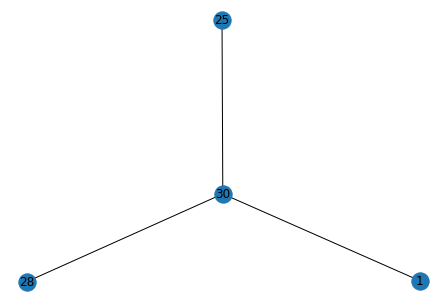

match_branches = [[1, 28]]
edges_to_delete (resolve crossover) = [[1, 25], [1, 30], [25, 28], [25, 30], [28, 30]]
edges_to_create (resolve crossover) = [[1, 28]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 25], [1, 30], [25, 28], [25, 30], [28, 30]]
edges_to_create = [[1, 28]]
Number of connected components = 4
Comp 0 = {0, 3, 13, 17, 20, 22, 23, 30, 31, 34, 35, 36, 39, 40, 42, 43, 44, 45, 46, 53, 54, 55, 58, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 79, 81, 82, 83, 84, 85, 86, 90, 91, 93}
Comp 1 = {1, 6, 21, 24, 28, 37, 38, 41, 47, 48, 49, 50, 56, 57, 59, 60, 69, 77, 78, 96, 97, 99, 100, 101, 102}
Comp 2 = {2, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 25, 26, 29, 32, 33, 51, 52, 80, 87, 88, 89, 92, 94, 95, 98}
Comp 3 = {27}
curr_limb_copy.deleted_edges = [[1, 25], [1, 30], [25, 28], [25, 30], [28, 30]]
curr_limb_copy.created_edges = [[1, 28]]
After get best cut: cut_edges = [[1, 25], [1, 30], [25, 28], [25, 30], [28, 3

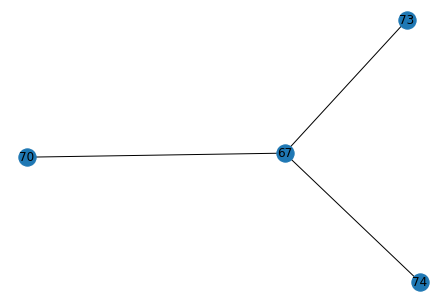

match_branches = []
edges_to_delete (resolve crossover) = [[67, 70], [67, 73], [67, 74], [70, 73], [70, 74], [73, 74]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[[1, 25], [1, 30], [25, 28], [25, 30], [28, 30]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[67, 70], [67, 73], [67, 74], [70, 73], [70, 74], [73, 74]]
edges_to_create = []
Number of connected components = 7
Comp 0 = {67}
Comp 1 = {0, 3, 13, 17, 20, 22, 23, 30, 31, 34, 35, 36, 39, 40, 42, 43, 44, 45, 46, 53, 54, 55, 58, 61, 62, 63, 64, 65, 66, 68, 70, 71, 72, 75, 76, 79, 81, 82, 83, 84, 85, 86, 90, 91, 93}
Comp 2 = {73}
Comp 3 = {74}
Comp 4 = {1, 6, 21, 24, 28, 37, 38, 41, 47, 48, 49, 50, 56, 57, 59, 60, 69, 77, 78, 96, 97, 99, 100, 101, 102}
Comp 5 = {2, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 25, 26, 29, 32, 33, 51, 52, 80, 87, 88, 89, 92, 94, 95, 98}
Comp 6 = {27}
curr_limb_copy.deleted_edges = [[1, 25], [1, 30], [25, 28], [25, 30], [28, 30], [67, 70], [67, 73], [67, 74], [70, 73],

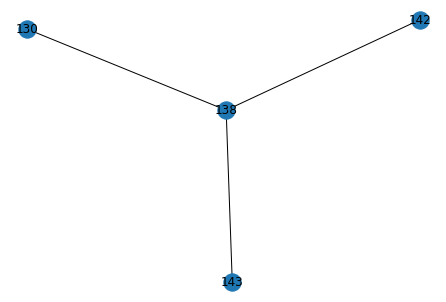

match_branches = [[130, 143], [138, 142]]
edges_to_delete (resolve crossover) = [[130, 138], [130, 142], [138, 143], [142, 143]]
edges_to_create (resolve crossover) = [[130, 143], [138, 142]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[130, 138], [130, 142], [138, 143], [142, 143]]
edges_to_create = [[130, 143], [138, 142]]
Number of connected components = 2
Comp 0 = {161, 162, 130, 163, 164, 165, 166, 141, 143, 151, 152, 120, 157, 158}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124

  Edge: [42 37]: curr_angle = 65.94
  Edge: [37 35]: curr_angle = 40.77
  Edge: [35 36]: curr_angle = 37.77
  Edge: [36 39]: curr_angle = 15.32
  Edge: [39 53]: curr_angle = 16.95
  Edge: [53 54]: curr_angle = 42.51
  Edge: [54 71]: curr_angle = 10.18
  Edge: [71 75]: curr_angle = 25.74
  Edge: [75 88]: curr_angle = 13.73
  Edge: [88 92]: curr_angle = 36.97
  Edge: [ 92 117]: curr_angle = 67.4
  Edge: [117 128]: curr_angle = 110.07
  Edge: [128 129]: curr_angle = 97.4
  Edge: [129 134]: curr_angle = 27.94
  Edge: [134 135]: curr_angle = 7.63
  Edge: [135 138]: curr_angle = 19.41
  Edge: [138 142]: curr_angle = 18.32
  Edge: [142 149]: curr_angle = 13.09
  Edge: [149 150]: curr_angle = 31.62
  Edge: [150 147]: curr_angle = 15.12
  Edge: [147 146]: curr_angle = 52.02

Total time for doubling_back = 1.9448246955871582
There were 1 edges that passed doubling back threshold of 100
Winning edge [117 128] had a doubling back of 110.06617284057779
***inside resolve crossover!!!!****
coordinate

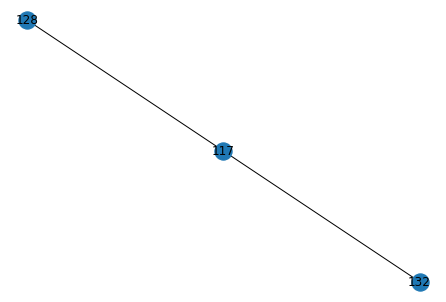

match_branches = []
edges_to_delete (resolve crossover) = [[117, 128], [117, 132], [128, 132]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([117, 128]), array([117, 132]), array([128, 132])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {161, 162, 130, 163, 164, 165, 166, 141, 143, 151, 152, 120, 157, 158}
Comp 1 = {128, 129, 131, 133, 134, 135, 136, 138, 140, 142, 145, 146, 147, 149, 150, 153, 89, 90, 96, 98, 108, 119, 122, 123, 124, 125, 126, 127}
Comp 2 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 121, 132, 137

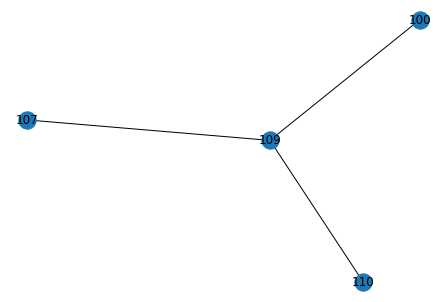

match_branches = []
edges_to_delete (resolve crossover) = [[100, 107], [100, 109], [100, 110], [107, 109], [107, 110], [109, 110]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[[130, 138], [130, 142], [138, 143], [142, 143], array([117, 128]), array([117, 132]), array([128, 132])]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[100, 107], [100, 109], [100, 110], [107, 109], [107, 110], [109, 110]]
edges_to_create = []
Number of connected components = 6
Comp 0 = {161, 162, 130, 163, 164, 165, 166, 141, 143, 151, 152, 120, 157, 158}
Comp 1 = {128, 129, 131, 133, 134, 135, 136, 138, 140, 142, 145, 146, 147, 149, 150, 153, 89, 90, 96, 98, 108, 119, 122, 123, 124, 125, 126, 127}
Comp 2 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,

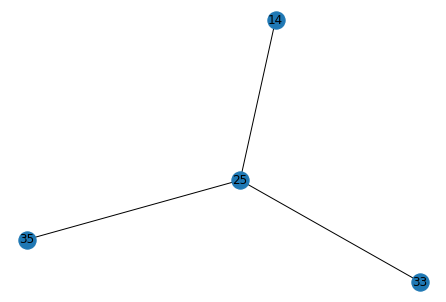

match_branches = [[25, 35], [14, 33]]
edges_to_delete (resolve crossover) = [[14, 25], [14, 35], [25, 33], [33, 35]]
edges_to_create (resolve crossover) = [[25, 35], [14, 33]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[14, 25], [14, 35], [25, 33], [33, 35]]
edges_to_create = [[25, 35], [14, 33]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83}
Comp 1 = {32}
Comp 2 = {57}
curr_limb_copy.deleted_edges = [[14, 25], [14, 35], [25, 33], [33, 35]]
curr_limb_copy.created_edges = [[25, 35], [14, 33]]
After get best cut: cut_edges = [[14, 25], [14, 35], [25, 33], [33, 35]], added_edges = [[25, 35], [14, 33]]
total_soma_paths_to_cut = []
--------

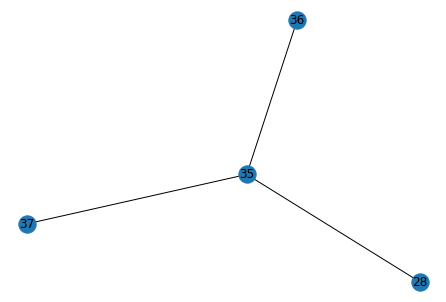

match_branches = [[35, 36], [28, 37]]
edges_to_delete (resolve crossover) = [[28, 35], [28, 36], [35, 37], [36, 37]]
edges_to_create (resolve crossover) = [[35, 36], [28, 37]]
curr_limb.deleted_edges 5 =[[14, 25], [14, 35], [25, 33], [33, 35]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[28, 35], [28, 36], [35, 37], [36, 37]]
edges_to_create = [[35, 36], [28, 37]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 60, 61, 62, 63, 64, 65, 66, 67, 70, 72, 79, 80}
Comp 1 = {5, 6, 15, 16, 18, 28, 37, 55, 56, 58, 59, 68, 69, 71, 73, 74, 75, 76, 77, 78, 81, 82, 83}
Comp 2 = {32}
Comp 3 = {57}
curr_limb_copy.deleted_edges = [[14, 25], [14, 35], [25, 33], [33, 35], [28, 35], [28, 36], [35, 37], [36, 37]]
curr_limb_copy.created_edges = [[25, 35], [14, 33], [35, 36], [28, 37]]
After get best cut: cut_edges = [[28, 

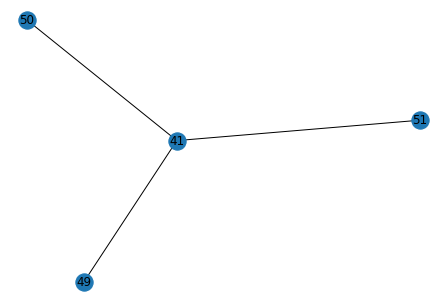

match_branches = [[41, 50]]
edges_to_delete (resolve crossover) = [[41, 49], [41, 51], [49, 50], [49, 51], [50, 51]]
edges_to_create (resolve crossover) = [[41, 50]]
curr_limb.deleted_edges 5 =[[14, 25], [14, 35], [25, 33], [33, 35], [28, 35], [28, 36], [35, 37], [36, 37]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[41, 49], [41, 51], [49, 50], [49, 51], [50, 51]]
edges_to_create = [[41, 50]]
Number of connected components = 6
Comp 0 = {0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 52, 53, 54, 60, 61, 62, 63, 64, 65, 66, 67, 70, 72}
Comp 1 = {5, 6, 15, 16, 18, 28, 37, 55, 56, 58, 59, 68, 69, 71, 73, 74, 75, 76, 77, 78, 81, 82, 83}
Comp 2 = {80, 49, 79}
Comp 3 = {51}
Comp 4 = {32}
Comp 5 = {57}
curr_limb_copy.deleted_edges = [[14, 25], [14, 35], [25, 33], [33, 35], [28, 35], [28, 36], [35, 37], [36, 37], [41, 49], [41, 51], [49, 50], [49, 51], [50, 51]]
curr_limb_

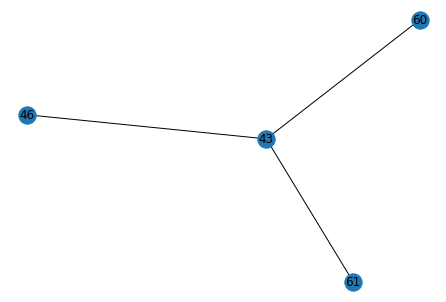

match_branches = [[46, 61]]
edges_to_delete (resolve crossover) = [[43, 46], [43, 60], [43, 61], [46, 60], [60, 61]]
edges_to_create (resolve crossover) = [[46, 61]]
curr_limb.deleted_edges 5 =[[14, 25], [14, 35], [25, 33], [33, 35], [28, 35], [28, 36], [35, 37], [36, 37], [41, 49], [41, 51], [49, 50], [49, 51], [50, 51]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[43, 46], [43, 60], [43, 61], [46, 60], [60, 61]]
edges_to_create = [[46, 61]]
Number of connected components = 8
Comp 0 = {0, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 53, 54, 62, 63, 64, 65, 66, 67}
Comp 1 = {5, 6, 15, 16, 18, 28, 37, 55, 56, 58, 59, 68, 69, 71, 73, 74, 75, 76, 77, 78, 81, 82, 83}
Comp 2 = {80, 49, 79}
Comp 3 = {51}
Comp 4 = {1, 70, 72, 46, 52, 61}
Comp 5 = {60}
Comp 6 = {32}
Comp 7 = {57}
curr_limb_copy.deleted_edges = [[14, 25], [14, 35], [25, 33], [33, 35], [28, 35], [28, 36], [35, 37], 

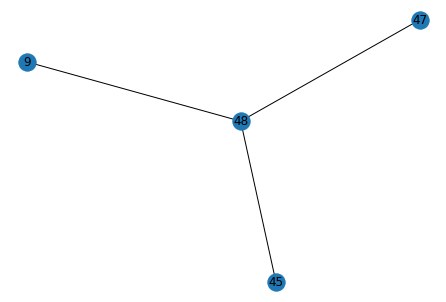

match_branches = [[45, 47], [9, 48]]
edges_to_delete (resolve crossover) = [[9, 45], [9, 47], [45, 48], [47, 48]]
edges_to_create (resolve crossover) = [[45, 47], [9, 48]]
curr_limb.deleted_edges 5 =[[14, 25], [14, 35], [25, 33], [33, 35], [28, 35], [28, 36], [35, 37], [36, 37], [41, 49], [41, 51], [49, 50], [49, 51], [50, 51], [43, 46], [43, 60], [43, 61], [46, 60], [60, 61]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[9, 45], [9, 47], [45, 48], [47, 48]]
edges_to_create = [[45, 47], [9, 48]]
Number of connected components = 9
Comp 0 = {45, 23, 53, 47}
Comp 1 = {0, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 17, 19, 20, 21, 22, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 48, 50, 54, 62, 63, 64, 65, 66, 67}
Comp 2 = {5, 6, 15, 16, 18, 28, 37, 55, 56, 58, 59, 68, 69, 71, 73, 74, 75, 76, 77, 78, 81, 82, 83}
Comp 3 = {80, 49, 79}
Comp 4 = {51}
Comp 5 = {1, 70, 72, 46, 52, 61}
Comp 6 = {60}
Comp 7 = {32}
Comp 8 = {57}
curr_limb_copy.deleted_edges = [[14, 25

  Edge: [14 13]: curr_angle = 30.48
  Edge: [13  8]: curr_angle = 6.07
  Edge: [8 9]: curr_angle = 46.31
  Edge: [ 9 10]: curr_angle = 177.56
  Edge: [10 15]: curr_angle = 21.49
  Edge: [15 19]: curr_angle = 83.13
  Edge: [19 18]: curr_angle = 51.0

Total time for doubling_back = 0.7537896633148193
There were 1 edges that passed doubling back threshold of 100
Winning edge [ 9 10] had a doubling back of 177.558854266482
***inside resolve crossover!!!!****
coordinate_branches = [6, 9, 10]
6 = red
9 = aqua
10 = purple
Angle between 6 and 9 = 39.75 
Angle between 6 and 10 = 11.06 
Angle between 9 and 10 = 131.53 
Final Matches = [[6, 10]]
matched_branches_revised = [[6, 10]]
Original graph


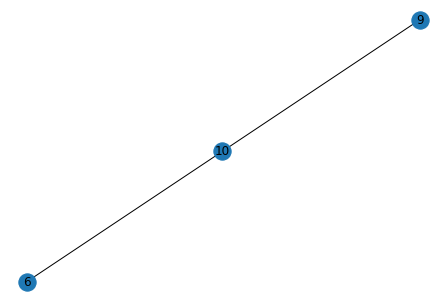

match_branches = [[6, 10]]
edges_to_delete (resolve crossover) = [[6, 9], [9, 10]]
edges_to_create (resolve crossover) = [[6, 10]]
edges_to_delete (cut_limb_network) = [array([6, 9]), array([ 9, 10])]
edges_to_create = [[6, 10]]
Number of connected components = 2
Comp 0 = {3, 6, 7, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}
Comp 1 = {0, 1, 2, 4, 5, 8, 9, 11, 12, 13, 14}
curr_limb_copy.deleted_edges = [array([6, 9]), array([ 9, 10])]
curr_limb_copy.created_edges = [[6, 10]]
After get best cut: cut_edges = [array([6, 9]), array([ 9, 10])], added_edges = [[6, 10]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection


---- working on disconnecting 14 and 35
---- This disconnects S0_1 from S0_2  
 Cut iter

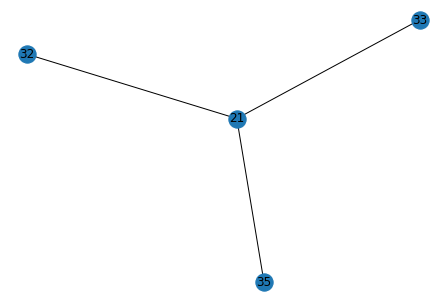

match_branches = [[32, 35]]
edges_to_delete (resolve crossover) = [[21, 32], [21, 33], [21, 35], [32, 33], [33, 35]]
edges_to_create (resolve crossover) = [[32, 35]]
curr_limb.deleted_edges 5 =[array([6, 9]), array([ 9, 10])]
Skipping endnode 35 because skeletal distance was 1853.0335335718516 and threshold was 2500
skip_nodes = [35]
edges_to_delete (cut_limb_network) = [[21, 32], [21, 33], [21, 35], [32, 33], [33, 35]]
edges_to_create = [[32, 35]]
Number of connected components = 5
Comp 0 = {3, 6, 7, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Comp 1 = {0, 1, 2, 4, 5, 8, 9, 11, 12, 13, 14}
Comp 2 = {32, 35, 36, 37, 38, 39, 40, 41, 42, 31}
Comp 3 = {33}
Comp 4 = {34}
curr_limb_copy.deleted_edges = [array([6, 9]), array([ 9, 10]), [21, 32], [21, 33], [21, 35], [32, 33], [33, 35]]
curr_limb_copy.created_edges = [[6, 10], [32, 35]]
After get best cut: cut_edges = [[21, 32], [21, 33], [21, 35], [32, 33], [33, 35]], added_edges = [[32, 35]]
total_soma_paths_to_cut = 

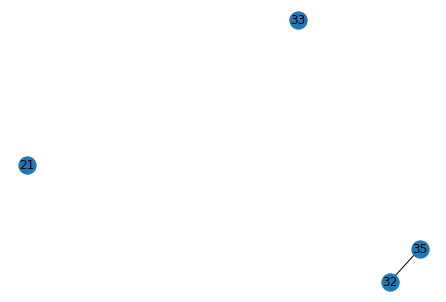

match_branches = [[32, 35]]
edges_to_delete (resolve crossover) = [[21, 32], [21, 33], [21, 35], [32, 33], [33, 35]]
edges_to_create (resolve crossover) = [[32, 35]]
curr_limb.deleted_edges 5 =[array([6, 9]), array([ 9, 10]), [21, 32], [21, 33], [21, 35], [32, 33], [33, 35]]
Skipping endnode 35 because skeletal distance was 1853.0335335718516 and threshold was 2500
skip_nodes = [35]
edges_to_delete (cut_limb_network) = [[21, 32], [21, 33], [21, 35], [32, 33], [33, 35]]
edges_to_create = [[32, 35]]
Number of connected components = 5
Comp 0 = {3, 6, 7, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Comp 1 = {0, 1, 2, 4, 5, 8, 9, 11, 12, 13, 14}
Comp 2 = {32, 35, 36, 37, 38, 39, 40, 41, 42, 31}
Comp 3 = {33}
Comp 4 = {34}
curr_limb_copy.deleted_edges = [array([6, 9]), array([ 9, 10]), [21, 32], [21, 33], [21, 35], [32, 33], [33, 35], [21, 32], [21, 33], [21, 35], [32, 33], [33, 35]]
curr_limb_copy.created_edges = [[6, 10], [32, 35], [32, 35]]
After get best cut: cut_e

  Edge: [32 36]: curr_angle = 28.45
  Edge: [36 40]: curr_angle = 101.33
  Edge: [40 39]: curr_angle = 95.15
  Edge: [39 38]: curr_angle = 62.95

Total time for doubling_back = 0.27347397804260254
There were 1 edges that passed doubling back threshold of 100
Winning edge [36 40] had a doubling back of 101.33050921156283
***inside resolve crossover!!!!****
coordinate_branches = [36, 40, 41]
36 = red
40 = aqua
41 = purple
Angle between 36 and 40 = 79.29 
Angle between 36 and 41 = 23.53 
Angle between 40 and 41 = 103.28 
Final Matches = [[36, 41]]
matched_branches_revised = [[36, 41]]
Original graph


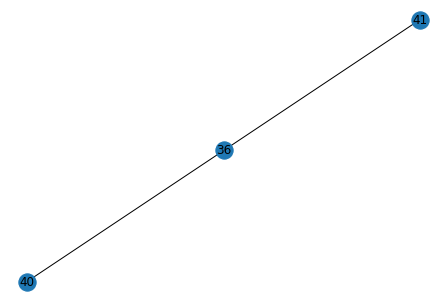

match_branches = [[36, 41]]
edges_to_delete (resolve crossover) = [[36, 40], [40, 41]]
edges_to_create (resolve crossover) = [[36, 41]]
edges_to_delete (cut_limb_network) = [array([36, 40]), array([40, 41])]
edges_to_create = [[36, 41]]
Number of connected components = 6
Comp 0 = {3, 6, 7, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Comp 1 = {0, 1, 2, 4, 5, 8, 9, 11, 12, 13, 14}
Comp 2 = {32, 35, 36, 37, 41}
Comp 3 = {33}
Comp 4 = {38, 39, 40, 42, 31}
Comp 5 = {34}
curr_limb_copy.deleted_edges = [array([6, 9]), array([ 9, 10]), [21, 32], [21, 33], [21, 35], [32, 33], [33, 35], [21, 32], [21, 33], [21, 35], [32, 33], [33, 35], array([36, 40]), array([40, 41])]
curr_limb_copy.created_edges = [[6, 10], [32, 35], [32, 35], [36, 41]]
After get best cut: cut_edges = [array([36, 40]), array([40, 41])], added_edges = [[36, 41]]
total_soma_paths_to_cut = [[21, 32], [21, 33], [21, 35], [32, 33], [33, 35]]
-----------counter = 1------------
 Cut iteration 2
Total number of

  Edge: [3 8]: curr_angle = 23.32
  Edge: [ 8 17]: curr_angle = 60.99
  Edge: [17 21]: curr_angle = 29.02
  Edge: [21 31]: curr_angle = 96.01
  Edge: [31 29]: curr_angle = 160.01
  Edge: [29 25]: curr_angle = 10.42
  Edge: [25 14]: curr_angle = 163.81
  Edge: [14  7]: curr_angle = 25.93
  Edge: [7 4]: curr_angle = 161.53

Total time for doubling_back = 0.418898344039917
There were 3 edges that passed doubling back threshold of 100
Winning edge [25 14] had a doubling back of 163.81090850843137
***inside resolve crossover!!!!****
coordinate_branches = [14, 24, 25]
14 = red
24 = aqua
25 = purple
Angle between 14 and 24 = 73.95 
Angle between 14 and 25 = 38.48 
Angle between 24 and 25 = 69.6 
Final Matches = []
matched_branches_revised = []
Original graph


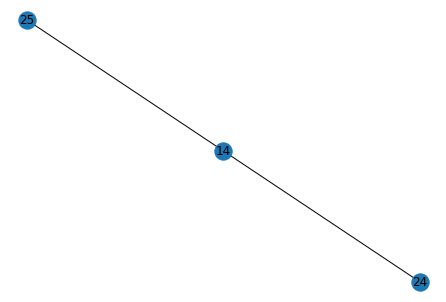

match_branches = []
edges_to_delete (resolve crossover) = [[14, 24], [14, 25], [24, 25]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([14, 24]), array([14, 25]), array([24, 25])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 5, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38}
Comp 1 = {4, 6, 7, 11, 12, 13, 14, 22, 23}
Comp 2 = {24, 26, 27}
curr_limb_copy.deleted_edges = [array([14, 24]), array([14, 25]), array([24, 25])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([14, 24]), array([14, 25]), array([24, 25])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([ 

  Edge: [73 58]: curr_angle = 28.55
  Edge: [58 61]: curr_angle = 31.36
  Edge: [61 17]: curr_angle = 16.54
  Edge: [17 16]: curr_angle = 117.22
  Edge: [16 18]: curr_angle = 33.9
  Edge: [18 31]: curr_angle = 20.48
  Edge: [31 55]: curr_angle = 88.13
  Edge: [55 50]: curr_angle = 21.36
  Edge: [50 48]: curr_angle = 85.2
  Edge: [48 65]: curr_angle = 23.46
  Edge: [65 71]: curr_angle = 44.98
  Edge: [71 75]: curr_angle = 147.06
  Edge: [75 77]: curr_angle = 45.32

Total time for doubling_back = 1.03226637840271
There were 2 edges that passed doubling back threshold of 100
Winning edge [71 75] had a doubling back of 147.064396465762
***inside resolve crossover!!!!****
coordinate_branches = [71, 75, 76]
71 = red
75 = aqua
76 = purple
Angle between 71 and 75 = 61.71 
Angle between 71 and 76 = 65.73 
Angle between 75 and 76 = 55.88 
Final Matches = []
matched_branches_revised = []
Original graph


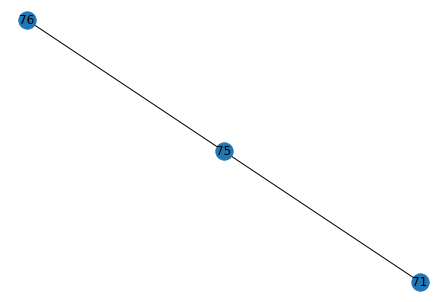

match_branches = []
edges_to_delete (resolve crossover) = [[71, 75], [71, 76], [75, 76]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([71, 75]), array([71, 76]), array([75, 76])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {22, 32, 33, 41, 44, 46, 47, 51, 52, 59, 72, 76, 78, 79, 80, 81, 83, 87, 91, 92, 93, 94, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181}
Comp 1 = {0, 1, 2, 6, 7, 8, 11, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 31, 37, 45, 48, 49, 50, 53, 54, 55, 56, 58, 60, 61, 62, 63, 64, 65, 67, 68, 70, 71, 73, 74, 82, 84, 85, 86, 88, 89, 90, 95, 96}
Comp 2 = {3, 4, 5, 9

  Edge: [0 1]: curr_angle = 26.38
  Edge: [1 2]: curr_angle = 59.91

Total time for doubling_back = 0.5489888191223145

Attempting the width jump check (attempting from both sides)
  Edge: [0 1]: jump = 55.44
  Edge: [1 2]: jump = 196.12
Total time for width = 0.6543912887573242
Path starting at 0 had err_edges: []
  Edge: [2 1]: jump = -196.12
  Edge: [1 0]: jump = -55.44
Total time for width = 0.5244350433349609
Path starting at 2 had err_edges: []
Did not find an error edge in either of the paths
Number of connected components = 1
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
curr_limb_copy.deleted_edges = []
curr_limb_copy.created_edges = []
After get best cut: cut_edges = None, added_edges = []
***** there was no suggested cut for this limb even though it is still connnected***
Total number of graphs at the end of the split = 1: [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 

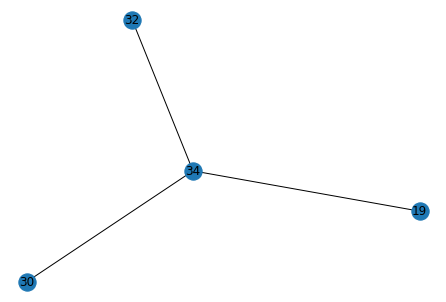

match_branches = [[19, 34], [30, 32]]
edges_to_delete (resolve crossover) = [[19, 30], [19, 32], [30, 34], [32, 34]]
edges_to_create (resolve crossover) = [[19, 34], [30, 32]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[19, 30], [19, 32], [30, 34], [32, 34]]
edges_to_create = [[19, 34], [30, 32]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 43, 44, 45, 46}
Comp 1 = {34, 4, 40, 41, 10, 42, 18, 19}
curr_limb_copy.deleted_edges = [[19, 30], [19, 32], [30, 34], [32, 34]]
curr_limb_copy.created_edges = [[19, 34], [30, 32]]
After get best cut: cut_edges = [[19, 30], [19, 32], [30, 34], [32, 34]], added_edges = [[19, 34], [30, 32]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the spl

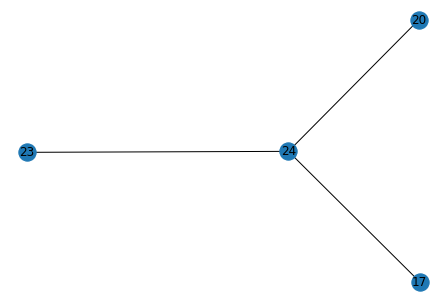

match_branches = [[23, 24]]
edges_to_delete (resolve crossover) = [[17, 20], [17, 23], [17, 24], [20, 23], [20, 24]]
edges_to_create (resolve crossover) = [[23, 24]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 12 because skeletal distance was 1187.1655479983135 and threshold was 2500
skip_nodes = [12]
edges_to_delete (cut_limb_network) = [[17, 20], [17, 23], [17, 24], [20, 23], [20, 24]]
edges_to_create = [[23, 24]]
Number of connected components = 3
Comp 0 = {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}
Comp 1 = {0, 1, 15, 16, 17}
Comp 2 = {20}
curr_limb_copy.deleted_edges = [[17, 20], [17, 23], [17, 24], [20, 23], [20, 24]]
curr_limb_copy.created_edges = [[23, 24]]
After get best cut: cut_edges = [[17, 20], [17, 23], [17, 24], [20, 23], [20, 24]], added_edges = [[23, 24]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 

  Edge: [14 19]: curr_angle = 20.97
  Edge: [19 24]: curr_angle = 36.64
  Edge: [24 23]: curr_angle = 12.07
  Edge: [23 21]: curr_angle = 24.2
  Edge: [21 28]: curr_angle = 34.0
  Edge: [28 30]: curr_angle = 20.84
  Edge: [30 32]: curr_angle = 38.92

Total time for doubling_back = 0.9185636043548584

Attempting the width jump check (attempting from both sides)
  Edge: [14 19]: jump = -124.68
  Edge: [19 24]: jump = 22.97
  Edge: [24 23]: jump = 266.05
Adding error edge [24 23] because width jump was 266.05372288389617
  Edge: [23 21]: jump = -23.85
  Edge: [21 28]: jump = -18.82
  Edge: [28 30]: jump = 156.05
  Edge: [30 32]: jump = -7.8
Total time for width = 0.9006476402282715
Path starting at 12 had err_edges: [[24, 23]]
  Edge: [32 30]: jump = 7.8
  Edge: [30 28]: jump = -97.6
  Edge: [28 21]: jump = -41.77
  Edge: [21 23]: jump = 23.85
  Edge: [23 24]: jump = -266.05
  Edge: [24 19]: jump = -22.97
  Edge: [19 14]: jump = 62.52
Total time for width = 0.7169697284698486
Path startin

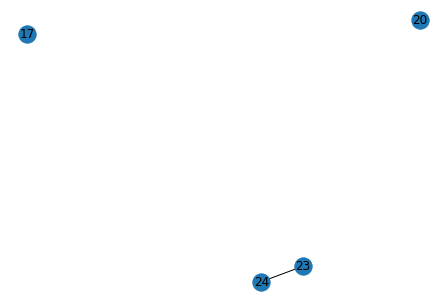

match_branches = [[20, 23]]
edges_to_delete (resolve crossover) = [[17, 20], [17, 23], [17, 24], [20, 24], [23, 24]]
edges_to_create (resolve crossover) = [[20, 23]]
edges_to_delete (cut_limb_network) = [array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24])]
edges_to_create = [[20, 23]]
Number of connected components = 3
Comp 0 = {32, 33, 34, 4, 5, 8, 9, 10, 20, 21, 22, 23, 28, 29, 30, 31}
Comp 1 = {0, 1, 15, 16, 17}
Comp 2 = {2, 3, 6, 7, 11, 12, 13, 14, 18, 19, 24, 25, 26, 27}
curr_limb_copy.deleted_edges = [[17, 20], [17, 23], [17, 24], [20, 23], [20, 24], array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24])]
curr_limb_copy.created_edges = [[23, 24], [20, 23]]
After get best cut: cut_edges = [array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24])], added_edges = [[20, 23]]
total_soma_paths_to_cut = [[17, 20], [17, 23], [17, 24], [20, 23], [20, 24]]
-----------counter = 1------------
 Cut iterati

  Edge: [14 19]: curr_angle = 20.97
  Edge: [19 24]: curr_angle = 36.64
  Edge: [24 23]: curr_angle = 12.07
  Edge: [23 21]: curr_angle = 24.2
  Edge: [21 28]: curr_angle = 34.0
  Edge: [28 30]: curr_angle = 20.84
  Edge: [30 32]: curr_angle = 38.92

Total time for doubling_back = 1.0726428031921387

Attempting the width jump check (attempting from both sides)
  Edge: [14 19]: jump = -124.68
  Edge: [19 24]: jump = 22.97
  Edge: [24 23]: jump = 266.05
Adding error edge [24 23] because width jump was 266.05372288389617
  Edge: [23 21]: jump = -23.85
  Edge: [21 28]: jump = -18.82
  Edge: [28 30]: jump = 156.05
  Edge: [30 32]: jump = -7.8
Total time for width = 0.9598433971405029
Path starting at 12 had err_edges: [[24, 23]]
  Edge: [32 30]: jump = 7.8
  Edge: [30 28]: jump = -97.6
  Edge: [28 21]: jump = -41.77
  Edge: [21 23]: jump = 23.85
  Edge: [23 24]: jump = -266.05
  Edge: [24 19]: jump = -22.97
  Edge: [19 14]: jump = 62.52
Total time for width = 0.7626805305480957
Path startin

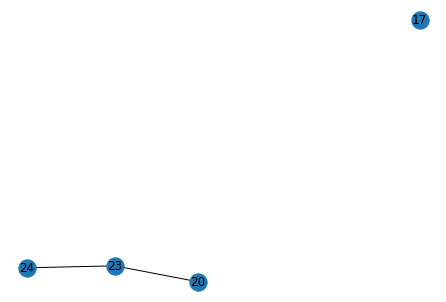

match_branches = [[20, 23]]
edges_to_delete (resolve crossover) = [[17, 20], [17, 23], [17, 24], [20, 24], [23, 24]]
edges_to_create (resolve crossover) = [[20, 23]]
edges_to_delete (cut_limb_network) = [array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24])]
edges_to_create = [[20, 23]]
Number of connected components = 3
Comp 0 = {32, 33, 34, 4, 5, 8, 9, 10, 20, 21, 22, 23, 28, 29, 30, 31}
Comp 1 = {0, 1, 15, 16, 17}
Comp 2 = {2, 3, 6, 7, 11, 12, 13, 14, 18, 19, 24, 25, 26, 27}
curr_limb_copy.deleted_edges = [[17, 20], [17, 23], [17, 24], [20, 23], [20, 24], array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24]), array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24])]
curr_limb_copy.created_edges = [[23, 24], [20, 23], [20, 23]]
After get best cut: cut_edges = [array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24])], added_edges = [[20, 23]]
**** there were no NEW sugges

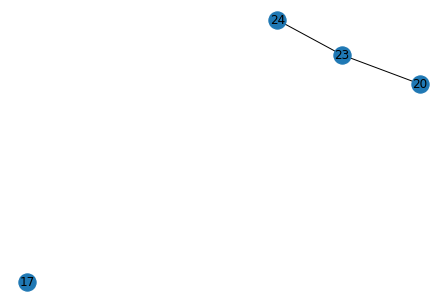

match_branches = [[23, 24]]
edges_to_delete (resolve crossover) = [[17, 20], [17, 23], [17, 24], [20, 23], [20, 24]]
edges_to_create (resolve crossover) = [[23, 24]]
curr_limb.deleted_edges 5 =[[17, 20], [17, 23], [17, 24], [20, 23], [20, 24], array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24]), array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24])]
Skipping endnode 12 because skeletal distance was 1187.1655479983135 and threshold was 2500
skip_nodes = [12]
edges_to_delete (cut_limb_network) = [[17, 20], [17, 23], [17, 24], [20, 23], [20, 24]]
edges_to_create = [[23, 24]]
Number of connected components = 3
Comp 0 = {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}
Comp 1 = {0, 1, 15, 16, 17}
Comp 2 = {20}
curr_limb_copy.deleted_edges = [[17, 20], [17, 23], [17, 24], [20, 23], [20, 24], array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24]

  Edge: [14 19]: curr_angle = 20.97
  Edge: [19 24]: curr_angle = 36.64
  Edge: [24 23]: curr_angle = 12.07
  Edge: [23 21]: curr_angle = 24.2
  Edge: [21 28]: curr_angle = 34.0
  Edge: [28  8]: curr_angle = 104.72
  Edge: [8 9]: curr_angle = 152.43
  Edge: [ 9 10]: curr_angle = 145.58
  Edge: [10 34]: curr_angle = 16.09

Total time for doubling_back = 1.5909442901611328
There were 3 edges that passed doubling back threshold of 100
Winning edge [8 9] had a doubling back of 152.43091448459364
***inside resolve crossover!!!!****
coordinate_branches = [4, 8, 9]
4 = red
8 = aqua
9 = purple
Angle between 4 and 8 = 36.13 
Angle between 4 and 9 = 57.05 
Angle between 8 and 9 = 159.05 
Final Matches = []
matched_branches_revised = []
Original graph


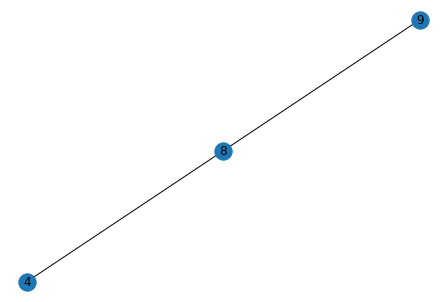

match_branches = []
edges_to_delete (resolve crossover) = [[4, 8], [4, 9], [8, 9]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([4, 8]), array([4, 9]), array([8, 9])]
edges_to_create = []
Number of connected components = 4
Comp 0 = {33, 34, 5, 9, 10}
Comp 1 = {4}
Comp 2 = {2, 3, 6, 7, 8, 11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}
Comp 3 = {0, 1, 15, 16, 17}
curr_limb_copy.deleted_edges = [[17, 20], [17, 23], [17, 24], [20, 23], [20, 24], array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24]), array([17, 20]), array([17, 23]), array([17, 24]), array([20, 24]), array([23, 24]), [17, 20], [17, 23], [17, 24], [20, 23], [20, 24], array([4, 8]), array([4, 9]), array([8, 9])]
curr_limb_copy.created_edges = [[23, 24], [20, 23], [20, 23], [23, 24]]
After get best cut: cut_edges = [array([4, 8]), array([4, 9]), array([8, 9])], added_edges = []
total_soma_paths_to_cut = [[17, 20], [17, 23], [17, 

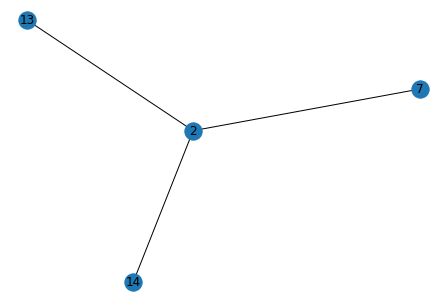

match_branches = [[7, 14]]
edges_to_delete (resolve crossover) = [[2, 7], [2, 13], [2, 14], [7, 13], [13, 14]]
edges_to_create (resolve crossover) = [[7, 14]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[2, 7], [2, 13], [2, 14], [7, 13], [13, 14]]
edges_to_create = [[7, 14]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 8, 9}
Comp 1 = {3, 4, 5, 6, 7, 14}
Comp 2 = {10, 11, 12, 13, 15, 16, 17, 18}
curr_limb_copy.deleted_edges = [[2, 7], [2, 13], [2, 14], [7, 13], [13, 14]]
curr_limb_copy.created_edges = [[7, 14]]
After get best cut: cut_edges = [[2, 7], [2, 13], [2, 14], [7, 13], [13, 14]], added_edges = [[7, 14]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([0, 

  Edge: [0 1]: curr_angle = 27.08

Total time for doubling_back = 0.23926925659179688

Attempting the width jump check (attempting from both sides)
  Edge: [0 1]: jump = 70.78
Total time for width = 0.22873592376708984
Path starting at 0 had err_edges: []
  Edge: [1 0]: jump = -70.78
Total time for width = 0.206787109375
Path starting at 1 had err_edges: []
Did not find an error edge in either of the paths
Number of connected components = 1
Comp 0 = {0, 1, 2}
curr_limb_copy.deleted_edges = []
curr_limb_copy.created_edges = []
After get best cut: cut_edges = None, added_edges = []
***** there was no suggested cut for this limb even though it is still connnected***
Total number of graphs at the end of the split = 1: [array([0, 1, 2])]


 ------ Total time for Splitting 864691135699307810 = 199.81164145469666 ------


----- Working on Neuron 864691135341171909-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [0 1]


 -------- Worki

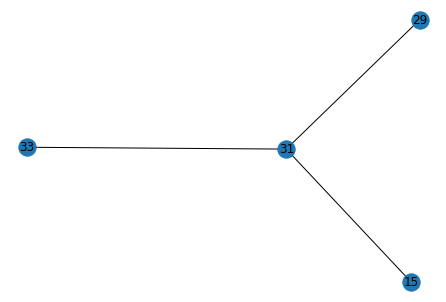

match_branches = [[29, 31], [15, 33]]
edges_to_delete (resolve crossover) = [[15, 29], [15, 31], [29, 33], [31, 33]]
edges_to_create (resolve crossover) = [[29, 31], [15, 33]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[15, 29], [15, 31], [29, 33], [31, 33]]
edges_to_create = [[29, 31], [15, 33]]
Number of connected components = 2
Comp 0 = {0, 6, 7, 18, 19, 21, 23, 24, 25, 29, 30, 31, 32, 34, 35, 37, 40, 41, 43, 44, 46, 47, 48, 51, 52, 54, 60, 61, 62, 63}
Comp 1 = {1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 26, 27, 28, 33, 36, 38, 39, 42, 45, 49, 50, 53, 55, 56, 57, 58, 59}
curr_limb_copy.deleted_edges = [[15, 29], [15, 31], [29, 33], [31, 33]]
curr_limb_copy.created_edges = [[29, 31], [15, 33]]
After get best cut: cut_edges = [[15, 29], [15, 31], [29, 33], [31, 33]], added_edges = [[29, 31], [15, 33]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split

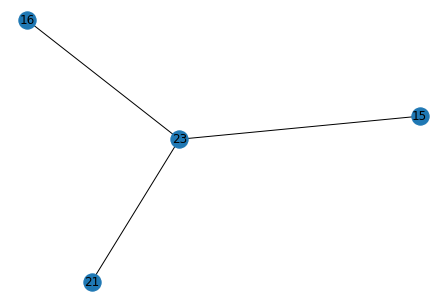

match_branches = [[16, 23]]
edges_to_delete (resolve crossover) = [[15, 16], [15, 21], [15, 23], [16, 21], [21, 23]]
edges_to_create (resolve crossover) = [[16, 23]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[15, 16], [15, 21], [15, 23], [16, 21], [21, 23]]
edges_to_create = [[16, 23]]
Number of connected components = 4
Comp 0 = {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36}
Comp 1 = {1, 21, 30}
Comp 2 = {20}
Comp 3 = {27}
curr_limb_copy.deleted_edges = [[15, 16], [15, 21], [15, 23], [16, 21], [21, 23]]
curr_limb_copy.created_edges = [[16, 23]]
After get best cut: cut_edges = [[15, 16], [15, 21], [15, 23], [16, 21], [21, 23]], added_edges = [[16, 23]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No va

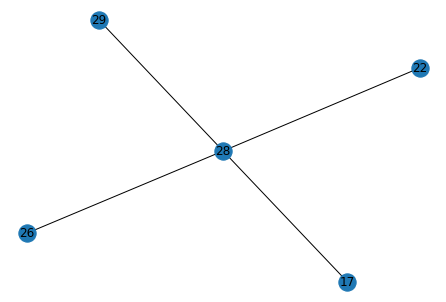

match_branches = [[17, 29], [22, 28]]
edges_to_delete (resolve crossover) = [[17, 22], [17, 26], [17, 28], [22, 26], [22, 29], [26, 28], [26, 29], [28, 29]]
edges_to_create (resolve crossover) = [[17, 29], [22, 28]]
curr_limb.deleted_edges 5 =[[15, 16], [15, 21], [15, 23], [16, 21], [21, 23]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[17, 22], [17, 26], [17, 28], [22, 26], [22, 29], [26, 28], [26, 29], [28, 29]]
edges_to_create = [[17, 29], [22, 28]]
Number of connected components = 6
Comp 0 = {18, 19, 22, 24, 25, 28}
Comp 1 = {32, 0, 2, 34, 3, 33, 4, 5, 7, 35, 36, 13, 17, 29}
Comp 2 = {6, 8, 9, 10, 11, 12, 14, 15, 16, 23, 26, 31}
Comp 3 = {1, 21, 30}
Comp 4 = {20}
Comp 5 = {27}
curr_limb_copy.deleted_edges = [[15, 16], [15, 21], [15, 23], [16, 21], [21, 23], [17, 22], [17, 26], [17, 28], [22, 26], [22, 29], [26, 28], [26, 29], [28, 29]]
curr_limb_copy.created_edges = [[16, 23], [17, 29], [22, 28]]
After get best cut: cut_edges = [[17, 22], [17, 26], [17, 28], [22, 26], [22

  Edge: [17 15]: curr_angle = 16.86
  Edge: [15 27]: curr_angle = 32.33
  Edge: [27  8]: curr_angle = 29.28
  Edge: [8 9]: curr_angle = 71.99
  Edge: [ 9 28]: curr_angle = 82.56
  Edge: [28 32]: curr_angle = 23.95
  Edge: [32 22]: curr_angle = 52.63

Total time for doubling_back = 1.4999840259552002

Attempting the width jump check (attempting from both sides)
  Edge: [17 15]: jump = -258.93
  Edge: [15 27]: jump = -34.75
  Edge: [27  8]: jump = -225.0
  Edge: [8 9]: jump = -201.7
  Edge: [ 9 28]: jump = 39.35
  Edge: [28 32]: jump = 51.46
  Edge: [32 22]: jump = 17.18
Total time for width = 0.9151630401611328
Path starting at 17 had err_edges: []
  Edge: [22 32]: jump = -17.18
  Edge: [32 28]: jump = -51.46
  Edge: [28  9]: jump = -39.35
  Edge: [9 8]: jump = 201.7
Adding error edge [9 8] because width jump was 201.70155596531362
  Edge: [ 8 27]: jump = 225.0
Adding error edge [ 8 27] because width jump was 225.00206317665885
  Edge: [27 15]: jump = 34.75
  Edge: [15 17]: jump = 258.9

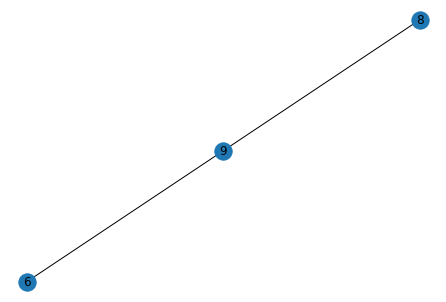

match_branches = [[6, 8]]
edges_to_delete (resolve crossover) = [[6, 9], [8, 9]]
edges_to_create (resolve crossover) = [[6, 8]]
edges_to_delete (cut_limb_network) = [array([6, 9]), array([8, 9])]
edges_to_create = [[6, 8]]
Number of connected components = 2
Comp 0 = {0, 1, 33, 3, 36, 6, 8, 13, 15, 17, 27, 29, 30, 31}
Comp 1 = {2, 4, 5, 7, 9, 10, 11, 12, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 32, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}
curr_limb_copy.deleted_edges = [array([6, 9]), array([8, 9])]
curr_limb_copy.created_edges = [[6, 8]]
After get best cut: cut_edges = [array([6, 9]), array([8, 9])], added_edges = [[6, 8]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIR

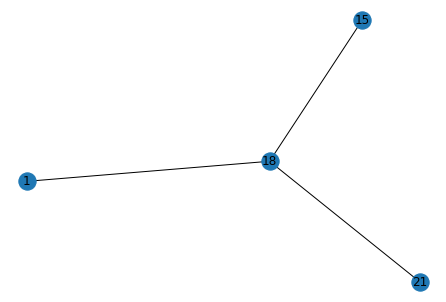

match_branches = [[15, 18]]
edges_to_delete (resolve crossover) = [[1, 15], [1, 18], [1, 21], [15, 21], [18, 21]]
edges_to_create (resolve crossover) = [[15, 18]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 16 because skeletal distance was 1706.605232623533 and threshold was 2500
skip_nodes = [16]
edges_to_delete (cut_limb_network) = [[1, 15], [1, 18], [1, 21], [15, 21], [18, 21]]
edges_to_create = [[15, 18]]
Number of connected components = 3
Comp 0 = {21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
Comp 1 = {1}
Comp 2 = {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
curr_limb_copy.deleted_edges = [[1, 15], [1, 18], [1, 21], [15, 21], [18, 21]]
curr_limb_copy.created_edges = [[15, 18]]
After get best cut: cut_edges = [[1, 15], [1, 18], [1, 21], [15, 21], [18, 21]], added_edges = [[15, 18]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graph

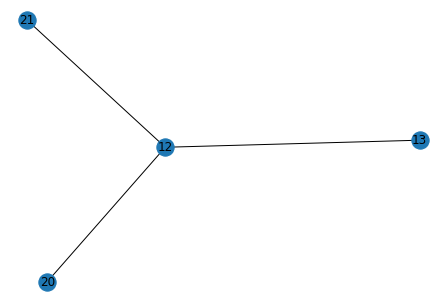

match_branches = [[13, 20], [12, 21]]
edges_to_delete (resolve crossover) = [[12, 13], [12, 20], [13, 21], [20, 21]]
edges_to_create (resolve crossover) = [[13, 20], [12, 21]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[12, 13], [12, 20], [13, 21], [20, 21]]
edges_to_create = [[13, 20], [12, 21]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}
Comp 1 = {20, 13}
Comp 2 = {19}
curr_limb_copy.deleted_edges = [[12, 13], [12, 20], [13, 21], [20, 21]]
curr_limb_copy.created_edges = [[13, 20], [12, 21]]
After get best cut: cut_edges = [[12, 13], [12, 20], [13, 21], [20, 21]], added_edges = [[13, 20], [12, 21]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the 

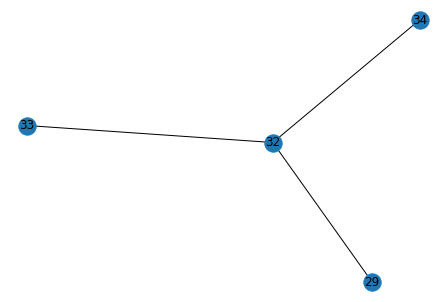

match_branches = []
edges_to_delete (resolve crossover) = [[29, 32], [29, 33], [29, 34], [32, 33], [32, 34], [33, 34]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[[12, 13], [12, 20], [13, 21], [20, 21]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[29, 32], [29, 33], [29, 34], [32, 33], [32, 34], [33, 34]]
edges_to_create = []
Number of connected components = 6
Comp 0 = {4, 15, 16, 29, 30}
Comp 1 = {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}
Comp 2 = {33}
Comp 3 = {34, 35, 36}
Comp 4 = {20, 13}
Comp 5 = {19}
curr_limb_copy.deleted_edges = [[12, 13], [12, 20], [13, 21], [20, 21], [29, 32], [29, 33], [29, 34], [32, 33], [32, 34], [33, 34]]
curr_limb_copy.created_edges = [[13, 20], [12, 21]]
After get best cut: cut_edges = [[29, 32], [29, 33], [29, 34], [32, 33], [32, 34], [33, 34]], added_edges = []
total_soma_paths_to_cut = [[12, 13], [12, 20], [13, 21], [20, 21]

  Edge: [1 3]: curr_angle = 53.06
  Edge: [ 3 10]: curr_angle = 38.64
  Edge: [10  6]: curr_angle = 119.96
  Edge: [6 4]: curr_angle = 39.83

Total time for doubling_back = 0.35567331314086914
There were 1 edges that passed doubling back threshold of 100
Winning edge [10  6] had a doubling back of 119.9555045932497
***inside resolve crossover!!!!****
coordinate_branches = [6, 10, 12]
6 = red
10 = aqua
12 = purple
Angle between 6 and 10 = 78.84 
Angle between 6 and 12 = 26.1 
Angle between 10 and 12 = 92.76 
Final Matches = [[6, 12]]
matched_branches_revised = [[6, 12]]
Original graph


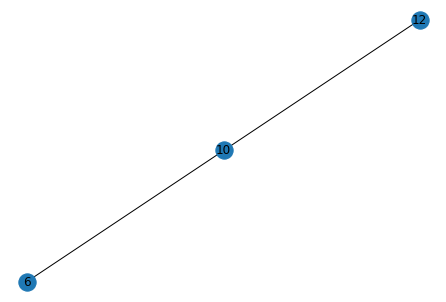

match_branches = [[6, 12]]
edges_to_delete (resolve crossover) = [[6, 10], [10, 12]]
edges_to_create (resolve crossover) = [[6, 12]]
edges_to_delete (cut_limb_network) = [array([ 6, 10]), array([10, 12])]
edges_to_create = [[6, 12]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 5, 7, 8, 10, 11, 13, 14}
Comp 1 = {9, 4, 12, 6}
curr_limb_copy.deleted_edges = [array([ 6, 10]), array([10, 12])]
curr_limb_copy.created_edges = [[6, 12]]
After get best cut: cut_edges = [array([ 6, 10]), array([10, 12])], added_edges = [[6, 12]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  5,  7,  8, 10, 11, 13, 14]), array([ 9,  4, 12,  6])]


 ------ Total time for Splitting 864691136908675694 = 51.0969

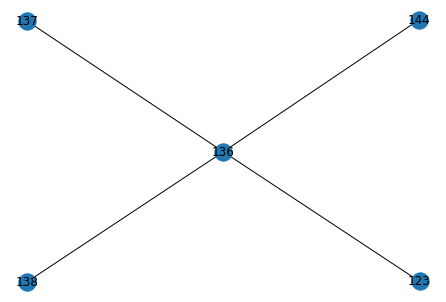

match_branches = [[136, 138], [123, 144]]
edges_to_delete (resolve crossover) = [[123, 136], [123, 137], [123, 138], [136, 137], [136, 144], [137, 138], [137, 144], [138, 144]]
edges_to_create (resolve crossover) = [[136, 138], [123, 144]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[123, 136], [123, 137], [123, 138], [136, 137], [136, 144], [137, 138], [137, 144], [138, 144]]
edges_to_create = [[136, 138], [123, 144]]
Number of connected components = 5
Comp 0 = {68, 42, 144, 210, 51, 123}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7.0, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 

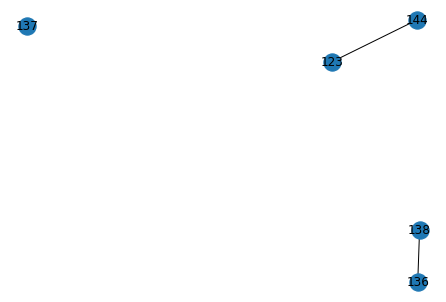

match_branches = [[136, 138], [123, 144]]
edges_to_delete (resolve crossover) = [[123, 136], [123, 137], [123, 138], [136, 137], [136, 144], [137, 138], [137, 144], [138, 144]]
edges_to_create (resolve crossover) = [[136, 138], [123, 144]]
curr_limb.deleted_edges 5 =[[123, 136], [123, 137], [123, 138], [136, 137], [136, 144], [137, 138], [137, 144], [138, 144]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[123, 136], [123, 137], [123, 138], [136, 137], [136, 144], [137, 138], [137, 144], [138, 144]]
edges_to_create = [[136, 138], [123, 144]]
Number of connected components = 5
Comp 0 = {68, 42, 144, 210, 51, 123}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7.0, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 9

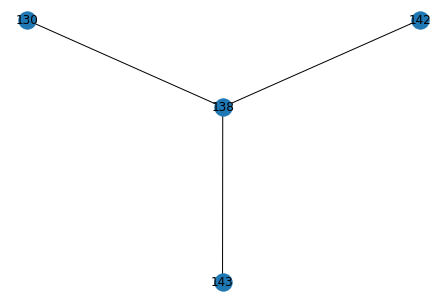

match_branches = [[130, 138]]
edges_to_delete (resolve crossover) = [[130, 142], [130, 143], [138, 142], [138, 143], [142, 143]]
edges_to_create (resolve crossover) = [[130, 138]]
curr_limb.deleted_edges 5 =[[123, 136], [123, 137], [123, 138], [136, 137], [136, 144], [137, 138], [137, 144], [138, 144], [123, 136], [123, 137], [123, 138], [136, 137], [136, 144], [137, 138], [137, 144], [138, 144]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[130, 142], [130, 143], [138, 142], [138, 143], [142, 143]]
edges_to_create = [[130, 138]]
Number of connected components = 7
Comp 0 = {68, 42, 144, 210, 51, 123}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7.0, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 

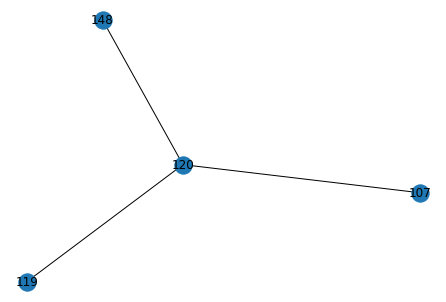

match_branches = [[119, 148], [107, 120]]
edges_to_delete (resolve crossover) = [[107, 119], [107, 148], [119, 120], [120, 148]]
edges_to_create (resolve crossover) = [[119, 148], [107, 120]]
curr_limb.deleted_edges 5 =[[123, 136], [123, 137], [123, 138], [136, 137], [136, 144], [137, 138], [137, 144], [138, 144], [123, 136], [123, 137], [123, 138], [136, 137], [136, 144], [137, 138], [137, 144], [138, 144], [130, 142], [130, 143], [138, 142], [138, 143], [142, 143]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[107, 119], [107, 148], [119, 120], [120, 148]]
edges_to_create = [[119, 148], [107, 120]]
Number of connected components = 8
Comp 0 = {68, 42, 144, 210, 51, 123}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7.0, 8, 9, 10, 11, 13, 14, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64, 67, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 9

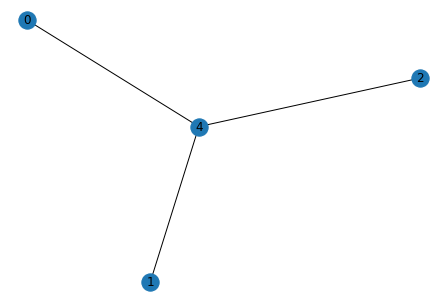

match_branches = [[0, 4], [1, 2]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [1, 4], [2, 4]]
edges_to_create (resolve crossover) = [[0, 4], [1, 2]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 5 because skeletal distance was 1545.683424229883 and threshold was 2500
skip_nodes = [5]
edges_to_delete (cut_limb_network) = [[0, 1], [0, 2], [1, 4], [2, 4]]
edges_to_create = [[0, 4], [1, 2]]
Number of connected components = 3
Comp 0 = {1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Comp 1 = {0, 4}
Comp 2 = {3}
curr_limb_copy.deleted_edges = [[0, 1], [0, 2], [1, 4], [2, 4]]
curr_limb_copy.created_edges = [[0, 4], [1, 2]]
After get best cut: cut_edges = [[0, 1], [0, 2], [1, 4], [2, 4]], added_edges = [[0, 4], [1, 2]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto t

In [12]:
start_time = time.time()
if not test_mode:
    time.sleep(random.randint(0, 800))
print('Populate Started')
if not test_mode:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
else:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
print('Populate Done')

print(f"Total time for NeuronSplitSuggestions populate = {time.time() - start_time}")

In [13]:
# import proofreading_utils as pru
# pru = reload(pru)
# du.create_suggested_splits_neuroglancer_spreadsheet(output_type="local")